In [4]:
import pandas as pd
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from PIL import Image
import pickle
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from tensorflow.keras.models import load_model
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
warnings.filterwarnings('ignore')

# 1. Business Understanding

**Business Objectives:

– Confirm the presence of a breast tumor:
Provide reliable support to the physician to determine whether the data indicate a suspicious tumor requiring medical intervention.

– Characterize the tumor to guide clinical decisions:
Offer clear indications on whether the tumor is benign or malignant.

– Detect early risk factors in healthy patients and recommend appropriate preventive actions.

**Data science objectives:

– Classify tumor type:
Build a model to distinguish between benign and malignant tumors based on imaging and clinical features. (dataset de base + dataset simple ajoutée)

– Detect tumor presence:
Develop a predictive model to classify patient data as indicative of a tumor or not, providing a reliable alert for potential breast cancer. (dataset image)

– Identify risk factors in healthy patients:
Analyze patient data to detect early indicators of increased breast cancer risk and generate actionable preventive recommendations.
(dataset de base + dataset simple ajoutée avec plus de concentration sur les variables qui traite la maladie)

# 2.Data Understanding

# 2.1 Data Understanding - Data article

# Data Loading & Initial Inspection

In [3]:
# Load the dataset
df = pd.read_csv('data.csv', header=0)

# Remove empty column if exists
if df.columns[-1] == 'NaN' or pd.isna(df.columns[-1]):
    df = df.iloc[:, :-1]

print(" WDBC Dataset Loaded Successfully!")
print(f" Dataset Shape: {df.shape}")
print(f" Samples: {df.shape[0]}, Features: {df.shape[1] - 2}")  # Excluding ID and diagnosis

# Display first few rows
print("\n First 5 Rows:")
print(df.head())

# Basic dataset information
print("\n Dataset Info:")
print(df.info())

# Column names
print(f"\n Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

 WDBC Dataset Loaded Successfully!
 Dataset Shape: (569, 33)
 Samples: 569, Features: 31

 First 5 Rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.1328

# Target Variable Analysis

Target Value Distribution:
   Benign (B): 357 samples (62.7%)
   Malignant (M): 212 samples (37.3%)


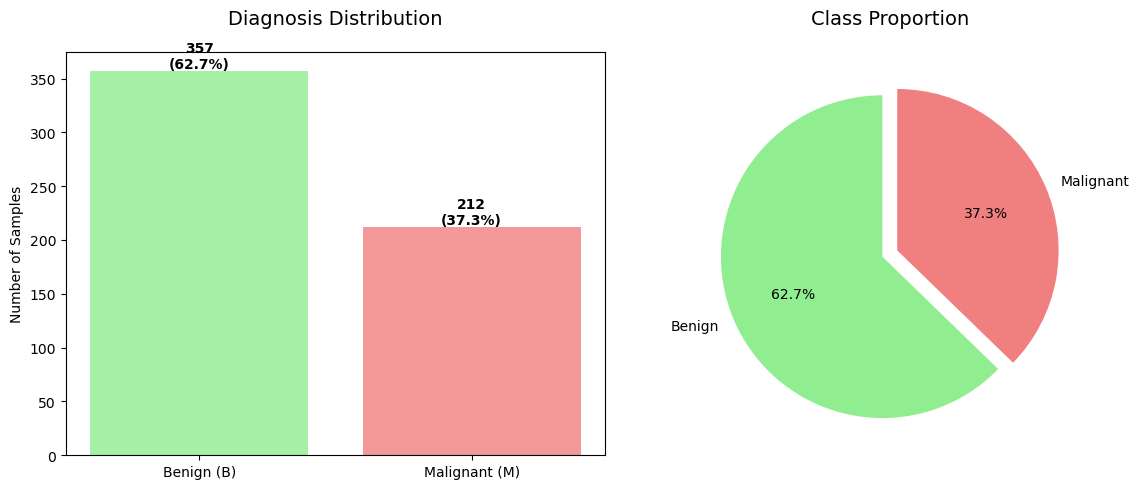

In [6]:
target_column = 'diagnosis' if 'diagnosis' in df.columns else df.columns[1]
target_dist = df[target_column].value_counts()

print("Target Value Distribution:")
print(f"   Benign (B): {target_dist['B']} samples ({target_dist['B']/len(df)*100:.1f}%)")
print(f"   Malignant (M): {target_dist['M']} samples ({target_dist['M']/len(df)*100:.1f}%)")

# Enhanced visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(['Benign (B)', 'Malignant (M)'], target_dist.values, 
               color=['lightgreen', 'lightcoral'], alpha=0.8)
plt.title('Diagnosis Distribution', fontsize=14, pad=20)
plt.ylabel('Number of Samples')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(target_dist.values, labels=['Benign', 'Malignant'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'],
        startangle=90, explode=(0.05, 0.05))
plt.title('Class Proportion', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

#  Feature Analysis

In [9]:
# Feature groups
mean_features = [col for col in df.columns if 'mean' in col]
se_features = [col for col in df.columns if '_se' in col]
worst_features = [col for col in df.columns if 'worst' in col]

print(f"\n Feature Categories:")
print(f"   Mean Features: {len(mean_features)}")
print(f"   Standard Error Features: {len(se_features)}")
print(f"   Worst Features: {len(worst_features)}")
print(f"   Total Features: {len(mean_features) + len(se_features) + len(worst_features)}")


 Feature Categories:
   Mean Features: 10
   Standard Error Features: 10
   Worst Features: 10
   Total Features: 30


# Data Quality Assessment

In [12]:
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('id')

# Missing values analysis
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values Analysis:")
print(missing_info[missing_info['Missing Values'] > 0])

if missing_info['Missing Values'].sum() == 0:
    print(" No missing values found!")
else:
    print(f" Total missing values: {missing_info['Missing Values'].sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f" Duplicate rows: {duplicates}")

# Check data types consistency
print(f"\n Data Types Analysis:")
print(df.dtypes.value_counts())

# Check for constant columns
constant_columns = []
for col in numeric_features:
    if df[col].nunique() == 1:
        constant_columns.append(col)

print(f" Constant columns: {len(constant_columns)}")

# Check for infinite values
infinite_values = np.isinf(df[numeric_features]).sum().sum()
print(f"  Infinite values: {infinite_values}")

Missing Values Analysis:
             Missing Values  Percentage
Unnamed: 32             569       100.0
 Total missing values: 569
 Duplicate rows: 0

 Data Types Analysis:
float64    31
int64       1
object      1
Name: count, dtype: int64
 Constant columns: 0
  Infinite values: 0


# Feature Distributions by Class

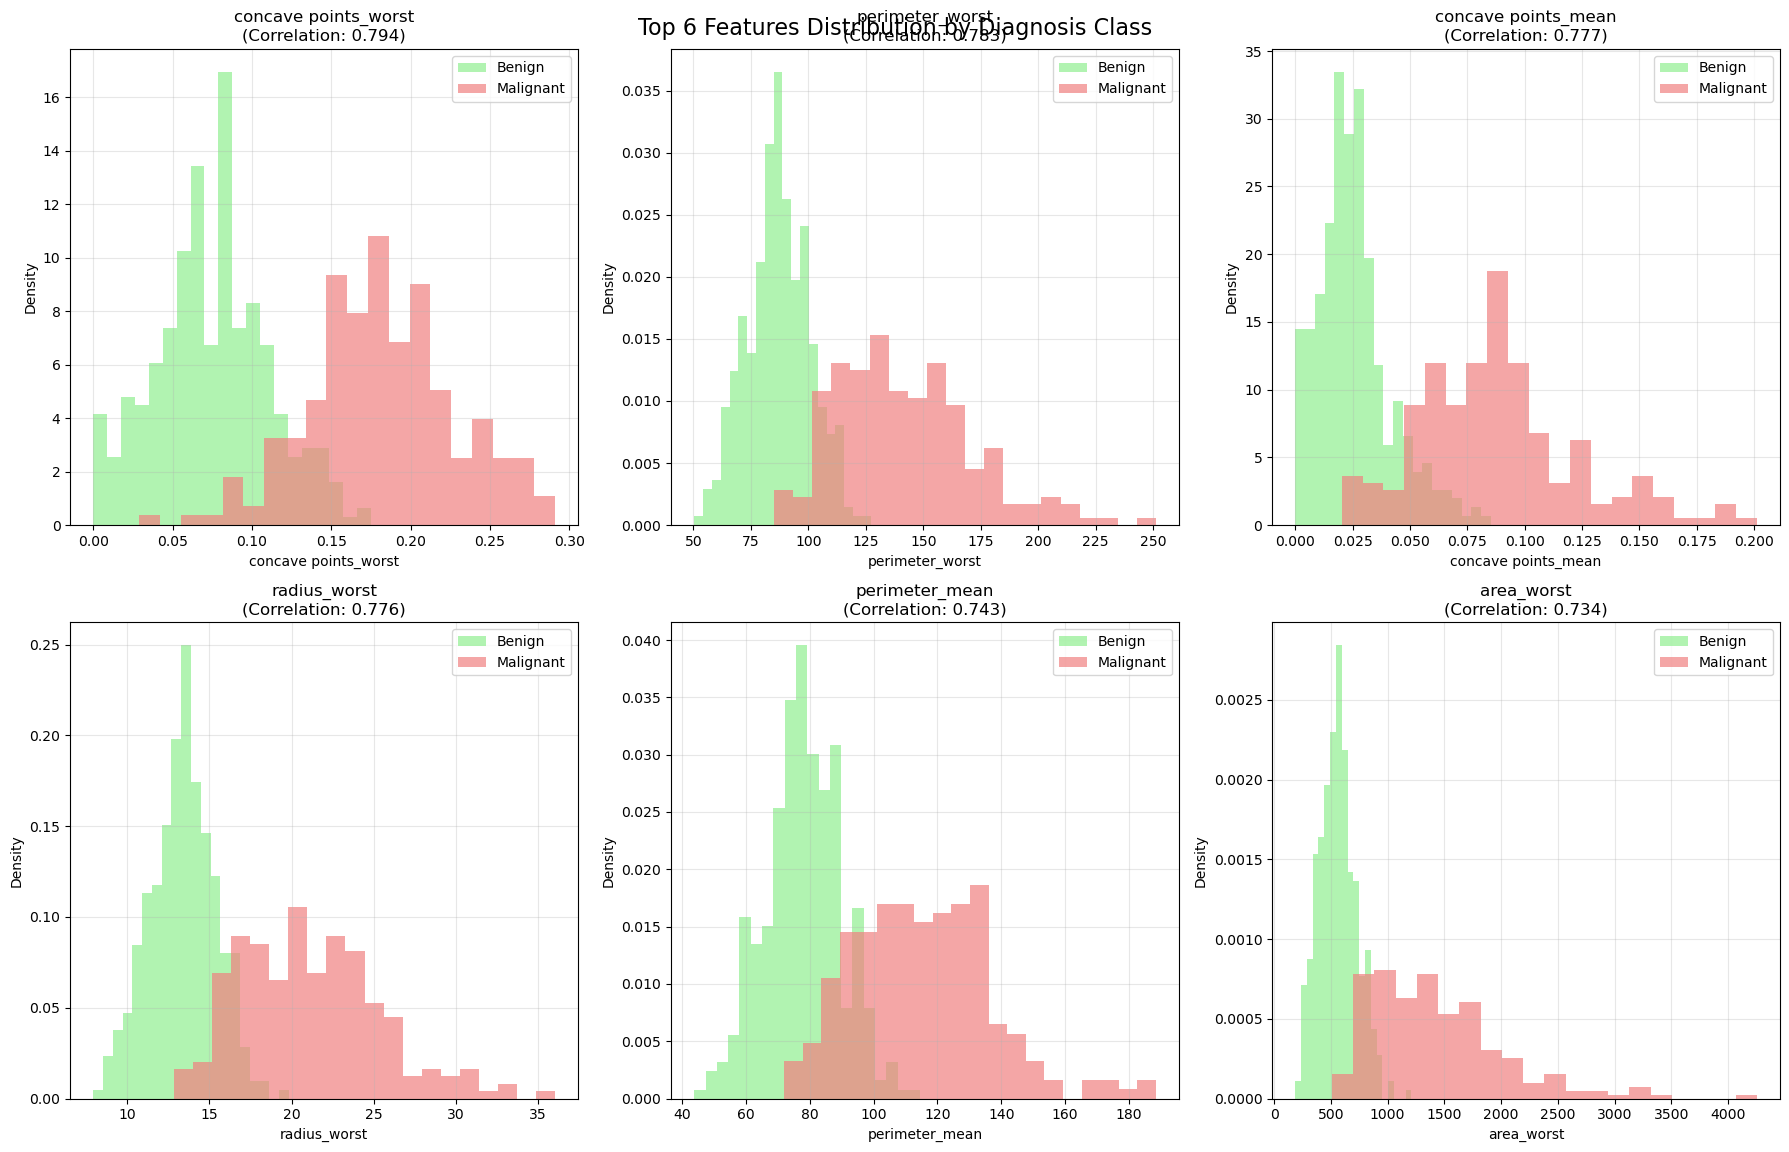

In [15]:
# Prepare data for visualization
X = df.drop(['id', target_column], axis=1)
y = df[target_column].map({'M': 1, 'B': 0})

# Select top 6 features for detailed visualization
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)
top_6_features = correlation_with_target.head(6).index

# Create comprehensive distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_6_features):
    # Plot distributions by class
    df[df[target_column] == 'B'][feature].hist(
        alpha=0.7, label='Benign', color='lightgreen', ax=axes[i], bins=20, density=True)
    df[df[target_column] == 'M'][feature].hist(
        alpha=0.7, label='Malignant', color='lightcoral', ax=axes[i], bins=20, density=True)
    
    correlation = correlation_with_target[feature]
    axes[i].set_title(f'{feature}\n(Correlation: {correlation:.3f})', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Top 6 Features Distribution by Diagnosis Class', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Correlation Analysis

Top 10 Features Correlated with Diagnosis:
    1. concave points_worst     :   0.794
    2. perimeter_worst          :   0.783
    3. concave points_mean      :   0.777
    4. radius_worst             :   0.776
    5. perimeter_mean           :   0.743
    6. area_worst               :   0.734
    7. radius_mean              :   0.730
    8. area_mean                :   0.709
    9. concavity_mean           :   0.696
   10. concavity_worst          :   0.660

Bottom 10 Features Correlated with Diagnosis:
    1. symmetry_mean            :   0.330
    2. fractal_dimension_worst  :   0.324
    3. compactness_se           :   0.293
    4. concavity_se             :   0.254
    5. fractal_dimension_se     :   0.078
    6. symmetry_se              :  -0.007
    7. texture_se               :  -0.008
    8. fractal_dimension_mean   :  -0.013
    9. smoothness_se            :  -0.067
   10. Unnamed: 32              :     nan


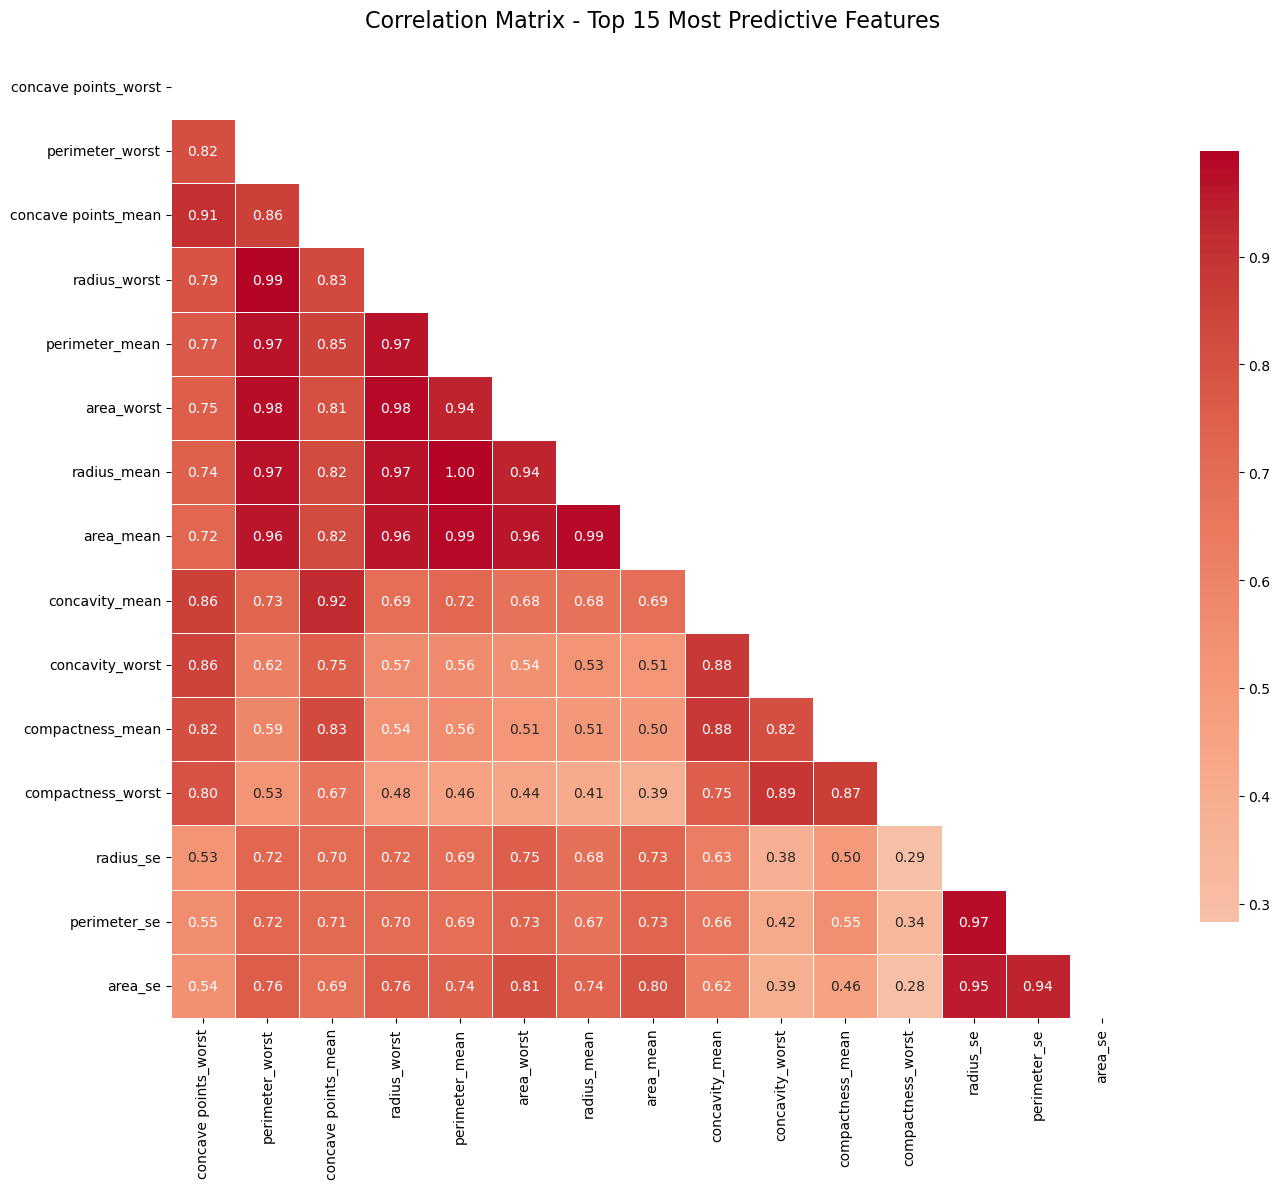

In [17]:
# Calculate correlation matrix
correlation_matrix = X.corrwith(y).sort_values(ascending=False)

print("Top 10 Features Correlated with Diagnosis:")
for i, (feature, corr) in enumerate(correlation_matrix.head(10).items(), 1):
    print(f"   {i:2d}. {feature:25}: {corr:7.3f}")

print(f"\nBottom 10 Features Correlated with Diagnosis:")
for i, (feature, corr) in enumerate(correlation_matrix.tail(10).items(), 1):
    print(f"   {i:2d}. {feature:25}: {corr:7.3f}")

# Visualize correlation heatmap for top 15 features
plt.figure(figsize=(15, 12))
top_15_features = correlation_matrix.head(15).index
corr_top_15 = X[top_15_features].corr()

mask = np.triu(np.ones_like(corr_top_15, dtype=bool))
sns.heatmap(corr_top_15, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Matrix - Top 15 Most Predictive Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Outlier Detection

Outlier Analysis (IQR method) - Top 10 Features:
                Feature  Outliers  Percentage
0  concave points_worst         0    0.000000
1       perimeter_worst        15    2.636204
2   concave points_mean        10    1.757469
3          radius_worst        17    2.987698
4        perimeter_mean        13    2.284710
5            area_worst        35    6.151142
6           radius_mean        14    2.460457
7             area_mean        25    4.393673
8        concavity_mean        18    3.163445
9       concavity_worst        12    2.108963


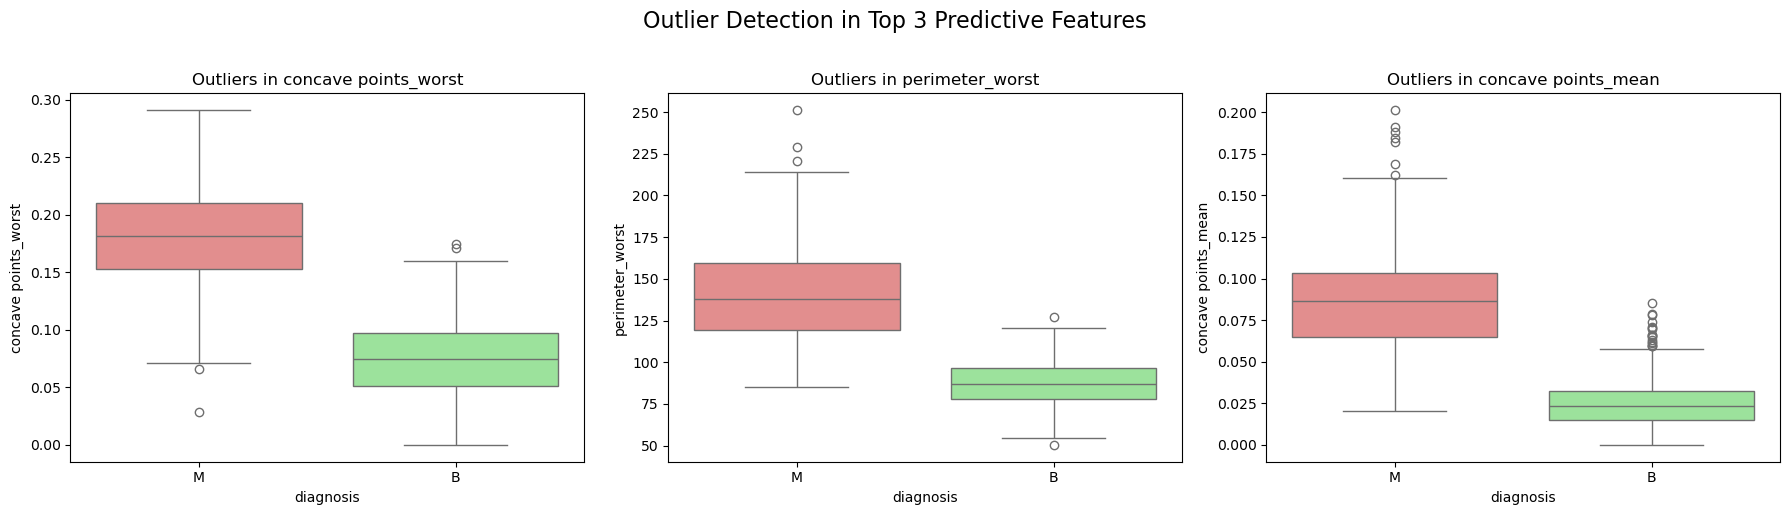

In [21]:
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return len(outliers)

print("Outlier Analysis (IQR method) - Top 10 Features:")
outlier_info = []
for feature in correlation_matrix.head(10).index:
    outliers_count = detect_outliers_iqr(df, feature)
    outlier_percentage = (outliers_count / len(df)) * 100
    outlier_info.append({
        'Feature': feature,
        'Outliers': outliers_count,
        'Percentage': outlier_percentage
    })

outlier_df = pd.DataFrame(outlier_info)
print(outlier_df)

# Visualize outliers for top 3 features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
top_3_features = correlation_matrix.head(3).index

for i, feature in enumerate(top_3_features):
    sns.boxplot(x=target_column, y=feature, data=df, ax=axes[i], 
                palette={'B': 'lightgreen', 'M': 'lightcoral'})
    axes[i].set_title(f'Outliers in {feature}')
    axes[i].set_ylabel(feature)

plt.suptitle('Outlier Detection in Top 3 Predictive Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 2.2 Data Understanding - Data clinic

# Data Loading & Initial Inspection

In [130]:
# Load the clinical dataset
clinical_df = pd.read_csv('data2.csv')  

print(" Clinical Dataset Loaded Successfully!")
print(f" Dataset Shape: {clinical_df.shape}")
print(f" Samples: {clinical_df.shape[0]}, Features: {clinical_df.shape[1]}")

# Display first few rows
print("\n First 5 Rows:")
print(clinical_df.head())

# Basic dataset information
print("\n Dataset Info:")
print(clinical_df.info())

# Column names
print(f"\n Column Names:")
for i, col in enumerate(clinical_df.columns, 1):
    print(f"   {i:2d}. {col}")

 Clinical Dataset Loaded Successfully!
 Dataset Shape: (4000, 10)
 Samples: 4000, Features: 10

 First 5 Rows:
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   54  35.207389      103    5.642  1.378660  65.6699     9.738408  31.17499   
1   52  22.978520      132    6.054  1.145435  47.5445     3.627241  23.03327   
2   32  21.101341       87    5.668  1.008595  50.5074     5.067841   9.51156   
3   42  26.761205      132    2.875  1.003837  16.8972    10.096475   9.75652   
4   55  34.232520       76    3.120  1.597721  17.6852    11.845054  17.21541   

     MCP.1  Classification  
0  197.660               1  
1  423.361               2  
2  897.034               2  
3  267.744               1  
4  788.552               2  

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age       

# Target Variable Analysis

In [135]:
# Analyze the target variable 'Classification'
target_column = 'Classification'
target_dist = clinical_df[target_column].value_counts().sort_index()

print("Target Value Distribution:")
print(f"   1 = Healthy controls: {target_dist[1]} samples ({target_dist[1]/len(clinical_df)*100:.1f}%)")
print(f"   2 = Patients: {target_dist[2]} samples ({target_dist[2]/len(clinical_df)*100:.1f}%)")

Target Value Distribution:
   1 = Healthy controls: 1784 samples (44.6%)
   2 = Patients: 2216 samples (55.4%)


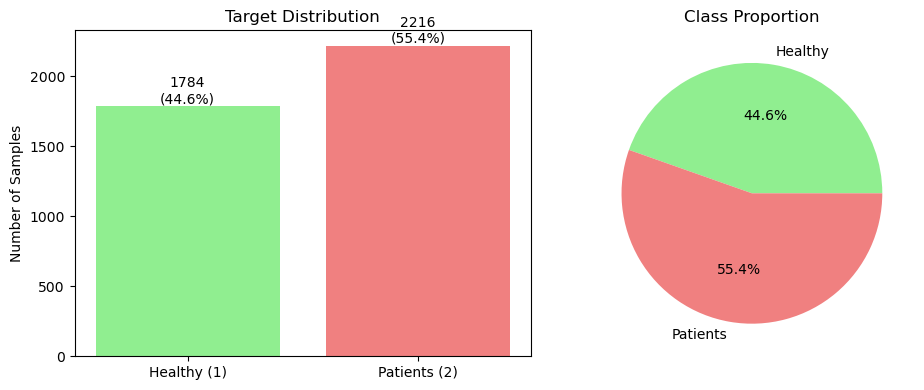

In [137]:
# Visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
bars = plt.bar(['Healthy (1)', 'Patients (2)'], target_dist.values, 
               color=['lightgreen', 'lightcoral'])
plt.title('Target Distribution')
plt.ylabel('Number of Samples')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}\n({height/len(clinical_df)*100:.1f}%)',
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(target_dist.values, labels=['Healthy', 'Patients'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Class Proportion')

plt.tight_layout()
plt.show()

# Feature Analysis & Description

In [140]:
# Feature descriptions based on attribute information
feature_descriptions = {
    'Age': 'Patient age in years',
    'BMI': 'Body Mass Index (kg/m²)',
    'Glucose': 'Blood glucose level (mg/dL)',
    'Insulin': 'Insulin level (µU/mL)',
    'HOMA': 'Homeostatic Model Assessment',
    'Leptin': 'Leptin hormone level (ng/mL)',
    'Adiponectin': 'Adiponectin level (µg/mL)',
    'Resistin': 'Resistin level (ng/mL)',
    'MCP.1': 'Monocyte Chemoattractant Protein-1 (pg/dL)'
}

print("Feature Descriptions:")
for feature, description in feature_descriptions.items():
    print(f"   • {feature}: {description}")

# Basic statistics
print(f"\n Statistical Summary:")
print(clinical_df.describe())

Feature Descriptions:
   • Age: Patient age in years
   • BMI: Body Mass Index (kg/m²)
   • Glucose: Blood glucose level (mg/dL)
   • Insulin: Insulin level (µU/mL)
   • HOMA: Homeostatic Model Assessment
   • Leptin: Leptin hormone level (ng/mL)
   • Adiponectin: Adiponectin level (µg/mL)
   • Resistin: Resistin level (ng/mL)
   • MCP.1: Monocyte Chemoattractant Protein-1 (pg/dL)

 Statistical Summary:
              Age          BMI      Glucose      Insulin         HOMA  \
count  4000.00000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     56.21075    27.422280   113.876500     8.654001     2.024332   
std      17.80965     4.413884    25.837795     6.435160     1.625638   
min      32.00000    20.690751    76.000000     2.821000     0.590033   
25%      39.00000    23.079053    76.000000     4.421750     0.970090   
50%      56.00000    27.558485   131.000000     5.818000     1.373842   
75%      72.00000    30.814916   134.000000    10.466250     2.502776   
max      

# Data Quality Assessment

In [143]:
# Missing values analysis
missing_values = clinical_df.isnull().sum()
missing_percentage = (missing_values / len(clinical_df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values Summary:")
print(missing_info[missing_info['Missing Values'] > 0])

if missing_info['Missing Values'].sum() == 0:
    print(" No missing values found!")
else:
    print(f"  Total missing values: {missing_info['Missing Values'].sum()}")

# Check for duplicates
duplicates = clinical_df.duplicated().sum()
print(f" Duplicate rows: {duplicates}")

# Check data types
print(f"\n Data Types:")
print(clinical_df.dtypes.value_counts())

Missing Values Summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
 No missing values found!
 Duplicate rows: 0

 Data Types:
float64    7
int64      3
Name: count, dtype: int64


# Feature Distributions by Class

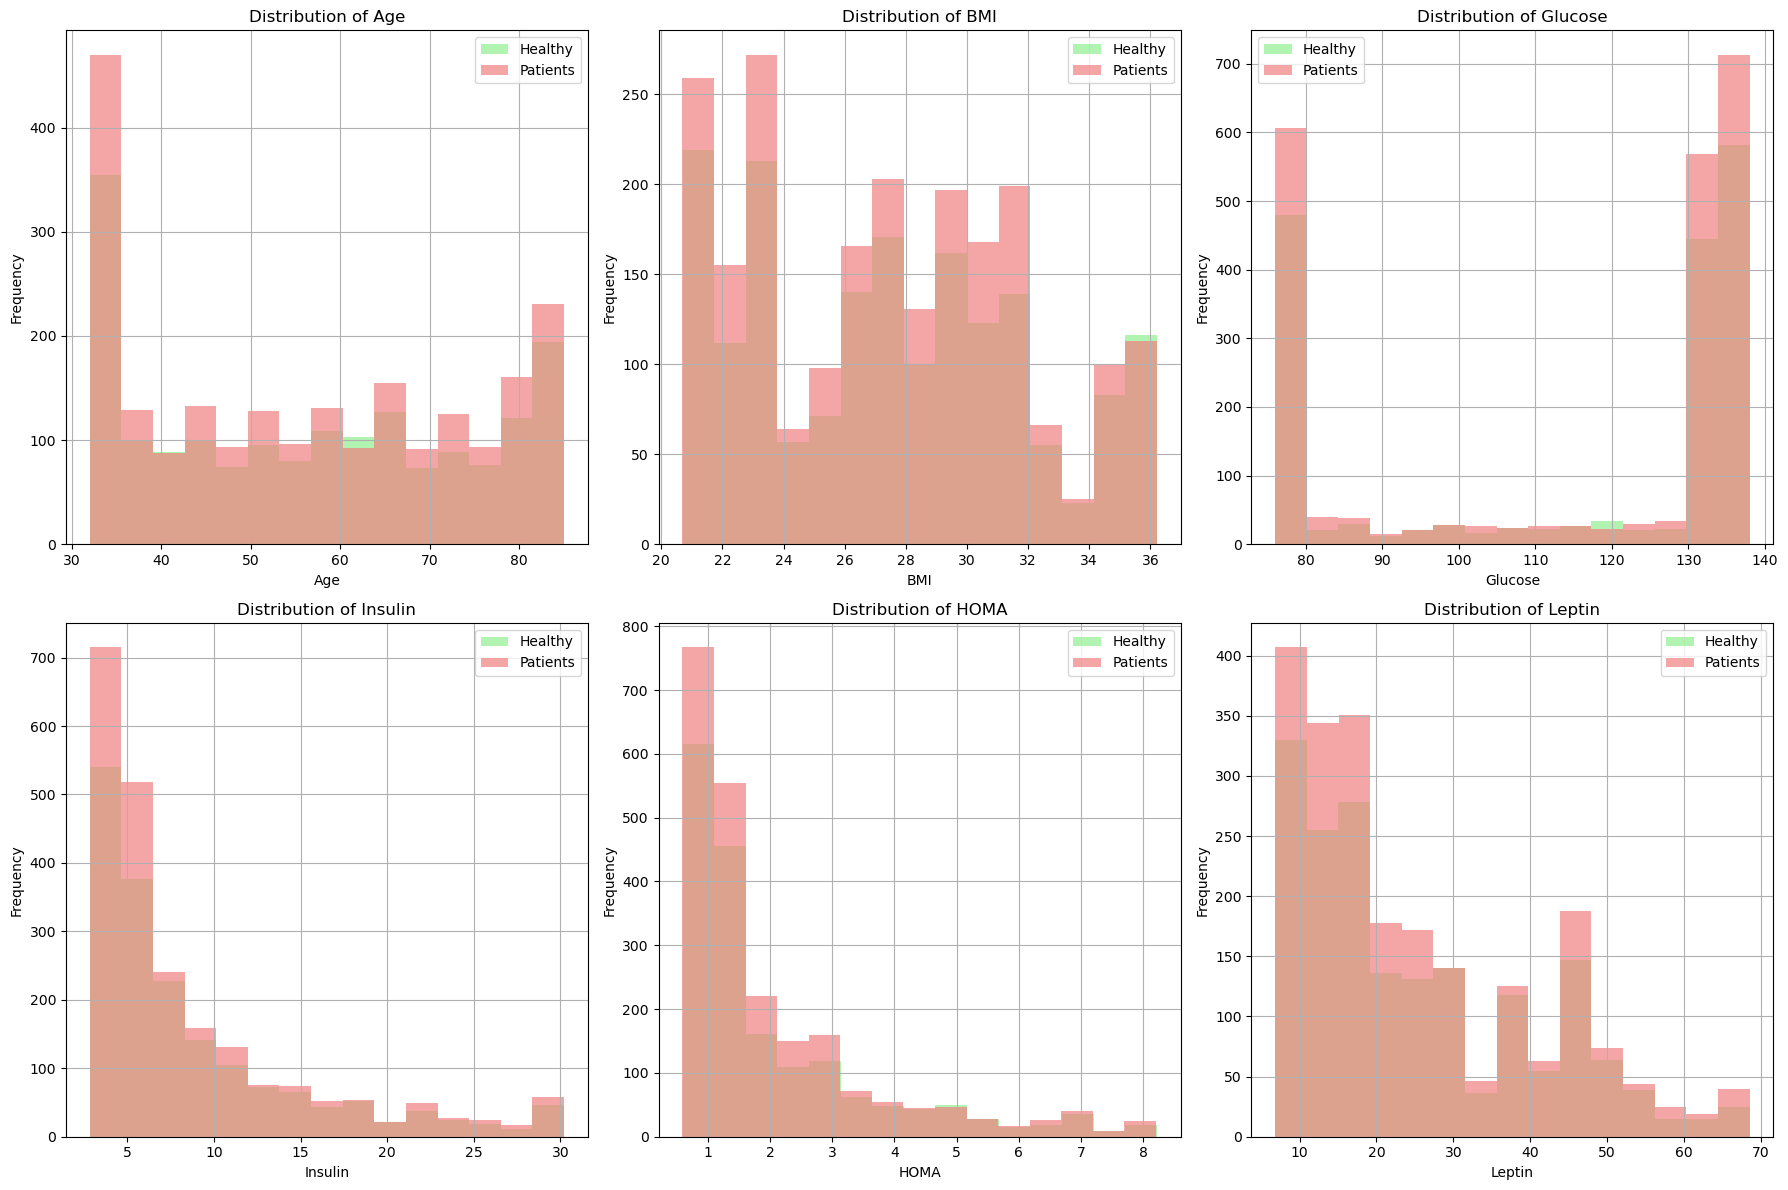

In [146]:
# Select numerical features (exclude target)
numerical_features = [col for col in clinical_df.columns if col != 'Classification']

# Create distribution plots for top 6 features
top_features = numerical_features[:6]  # First 6 features

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # Plot distributions by class
    clinical_df[clinical_df['Classification'] == 1][feature].hist(
        alpha=0.7, label='Healthy', color='lightgreen', ax=axes[i], bins=15)
    clinical_df[clinical_df['Classification'] == 2][feature].hist(
        alpha=0.7, label='Patients', color='lightcoral', ax=axes[i], bins=15)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Correlation Analysis

Feature Correlations with Target (Classification):
   Resistin       :   0.026
   MCP.1          :   0.006
   Glucose        :  -0.005
   Leptin         :  -0.005
   Adiponectin    :  -0.007
   Age            :  -0.008
   BMI            :  -0.009
   HOMA           :  -0.012
   Insulin        :  -0.017


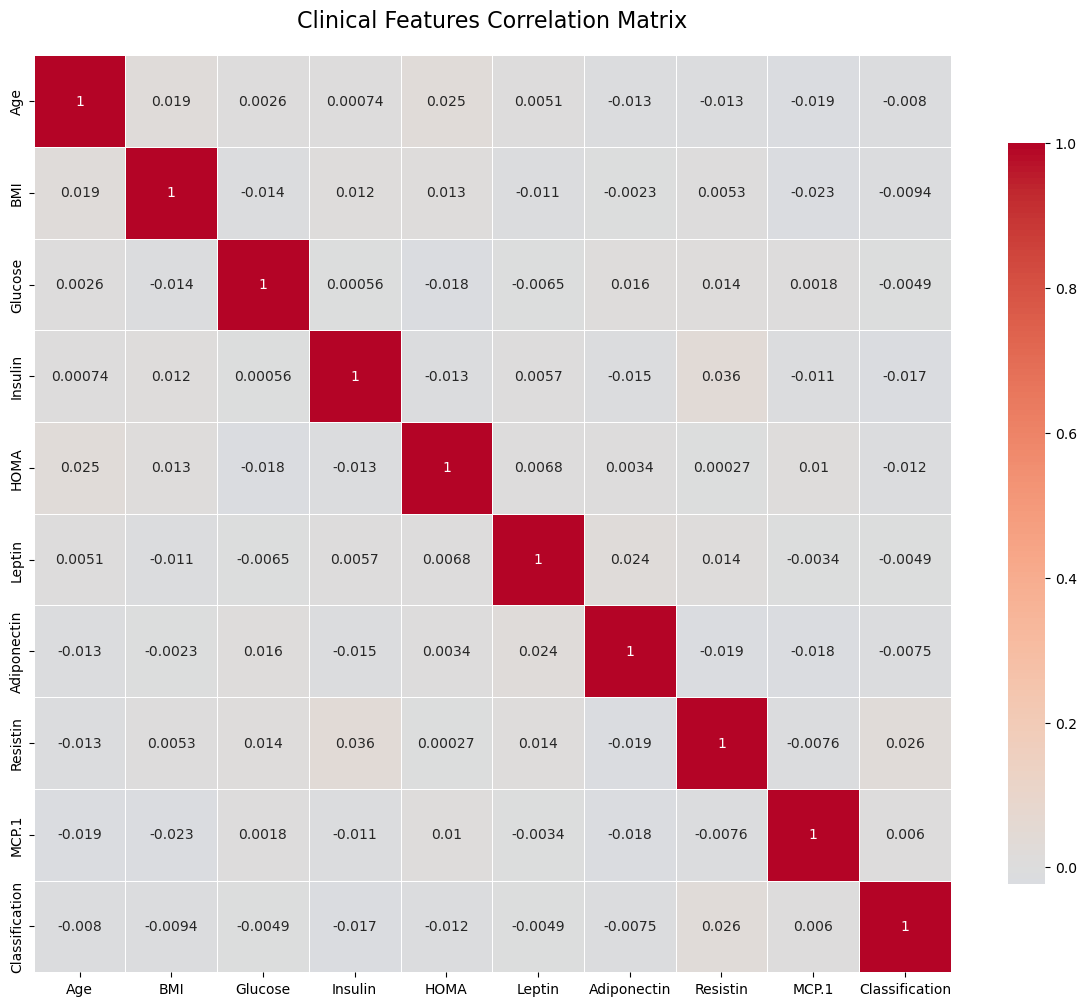

In [149]:
# Calculate correlation matrix
correlation_matrix = clinical_df.corr()

# Correlation with target variable
target_correlations = correlation_matrix['Classification'].sort_values(ascending=False)

print("Feature Correlations with Target (Classification):")
for feature, corr in target_correlations.items():
    if feature != 'Classification':
        print(f"   {feature:15}: {corr:7.3f}")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Clinical Features Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Outlier Detection

In [152]:
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return len(outliers)

print("Outlier Analysis (IQR method):")
outlier_info = []
for feature in numerical_features:
    outliers_count = detect_outliers_iqr(clinical_df, feature)
    outlier_percentage = (outliers_count / len(clinical_df)) * 100
    outlier_info.append({
        'Feature': feature,
        'Outliers': outliers_count,
        'Percentage': outlier_percentage
    })

outlier_df = pd.DataFrame(outlier_info)
print(outlier_df)

Outlier Analysis (IQR method):
       Feature  Outliers  Percentage
0          Age         0       0.000
1          BMI         0       0.000
2      Glucose         0       0.000
3      Insulin       352       8.800
4         HOMA       343       8.575
5       Leptin         0       0.000
6  Adiponectin       281       7.025
7     Resistin        62       1.550
8        MCP.1         0       0.000


# Key Insights for Risk Factor Identification

In [155]:
# Analyze features with highest correlation to patient status
high_corr_features = target_correlations[1:4]  # Top 3 features (excluding target itself)

print("Top Features Correlated with Patient Status:")
for feature, corr in high_corr_features.items():
    # Calculate mean values by class
    healthy_mean = clinical_df[clinical_df['Classification'] == 1][feature].mean()
    patient_mean = clinical_df[clinical_df['Classification'] == 2][feature].mean()
    
    print(f"   • {feature}:")
    print(f"        Correlation: {corr:.3f}")
    print(f"        Healthy mean: {healthy_mean:.2f}")
    print(f"        Patient mean: {patient_mean:.2f}")
    print(f"        Difference: {patient_mean - healthy_mean:.2f}")

# Potential risk factors based on medical knowledge
print(f"\n POTENTIAL RISK FACTORS ANALYSIS:")
print(f"   • BMI: Higher BMI may correlate with increased cancer risk")
print(f"   • Glucose/Insulin: Metabolic factors linked to cancer risk")
print(f"   • Hormone levels (Leptin, Adiponectin, Resistin): Adipokines related to obesity and cancer")
print(f"   • MCP-1: Inflammatory marker associated with cancer progression")

Top Features Correlated with Patient Status:
   • Resistin:
        Correlation: 0.026
        Healthy mean: 12.84
        Patient mean: 13.23
        Difference: 0.39
   • MCP.1:
        Correlation: 0.006
        Healthy mean: 510.49
        Patient mean: 513.55
        Difference: 3.06
   • Glucose:
        Correlation: -0.005
        Healthy mean: 114.02
        Patient mean: 113.76
        Difference: -0.25

 POTENTIAL RISK FACTORS ANALYSIS:
   • BMI: Higher BMI may correlate with increased cancer risk
   • Glucose/Insulin: Metabolic factors linked to cancer risk
   • Hormone levels (Leptin, Adiponectin, Resistin): Adipokines related to obesity and cancer
   • MCP-1: Inflammatory marker associated with cancer progression


# 2.3 Data Understanding - Data images

In [4]:
root = r"Images histopathologies" 

# Regex pattern that enforces the expected naming convention:
# patientID_idx*_x*_y*_class*.png
pattern = re.compile(r'^[0-9]+_idx[0-9]+_x[0-9]+_y[0-9]+_class[01]\.png$')

bad_files = []
total = 0

for root_dir, _, files in os.walk(root):
    for f in files:
        if f.lower().endswith(".png"):
            total += 1
            if not pattern.match(f):
                # Check if filename respects the expected format
                bad_files.append(os.path.join(root_dir, f))

print(f"Total PNG files scanned: {total}")
print(f"Invalid filenames found: {len(bad_files)}\n")

# Print examples of invalid filenames if any
if bad_files:
    for bf in bad_files[:30]:
        print("BAD:", bf)
    if len(bad_files) > 30:
        print("... and more.")
else:
    print("All filenames are valid.")

Total PNG files scanned: 277524
Invalid filenames found: 0

All filenames are valid.


In [6]:
# Counters for total images and per-class images
total_count = 0
class_0_count = 0
class_1_count = 0

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for class_label in ["0", "1"]:
        class_path = os.path.join(patient_path, class_label)
        if not os.path.isdir(class_path):
            continue
        
        count = len([f for f in os.listdir(class_path)
                     if f.endswith(".png")])

        total_count += count

        if class_label == "0":
            class_0_count += count
        else:
            class_1_count += count

print("Total images:", total_count)
print("Class 0 (non-IDC):", class_0_count)
print("Class 1 (IDC):", class_1_count)

Total images: 277524
Class 0 (non-IDC): 198738
Class 1 (IDC): 78786


In [8]:
rows = []

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for fname in os.listdir(label_path):
            if fname.endswith(".png"):
                rows.append({
                    "patient_id": int(patient_id),
                    "label": int(label),
                    "filename": os.path.join(label_path, fname)
                })

df = pd.DataFrame(rows)
print(df.head())
print(df.shape)

   patient_id  label                                           filename
0       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
1       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
2       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
3       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
4       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
(277524, 3)


In [12]:
#datasets des id des patients
patients = df["patient_id"].unique()

train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_patients, test_size=0.1, random_state=42)

df_train_images = df[df["patient_id"].isin(train_patients)]
df_val_images = df[df["patient_id"].isin(val_patients)]
df_test_images = df[df["patient_id"].isin(test_patients)]

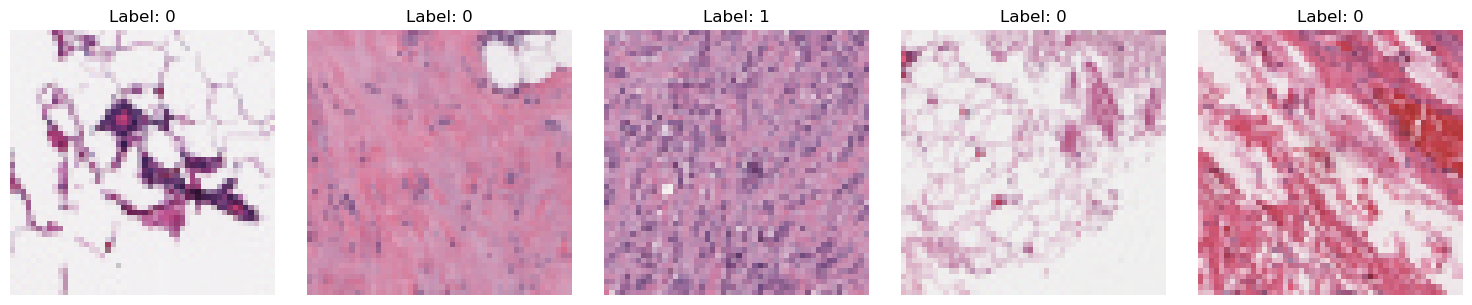

In [14]:
def Images_samples(df, n=5):
    # Randomly sample n images
    sample = df.sample(n)

    plt.figure(figsize=(15, 3))

    for i, (_, row) in enumerate(sample.iterrows()):
        img = Image.open(row["filename"])

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {row['label']}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Images_samples(df_train_images, n=5)

## Data Understanding Images dataset – Conclusions

**Conclusions**
- The dataset follows a strict and consistent naming convention.
- Class distribution can be quantified early, allowing us to anticipate imbalance issues.
- Patient-wise splitting is critical to avoid data leakage in medical imaging.
- Visual inspection confirms meaningful texture and structural patterns.

# 3.Data Preparation

# 3.1 Data Preparation - Data article

# Data Loading & Target Encoding

In [6]:
# Load the dataset
df = pd.read_csv('data.csv', header=0)

# Remove empty column if exists
if df.columns[-1] == 'NaN' or pd.isna(df.columns[-1]):
    df = df.iloc[:, :-1]

print(" Dataset loaded successfully!")
print(f"   Shape: {df.shape}")

# Identify target column (assuming it's the second column as per WDBC standard)
target_column = 'diagnosis' if 'diagnosis' in df.columns else df.columns[1]
print(f" Target column: {target_column}")

# Encode target variable: M=1, B=0 (Malignant=1, Benign=0)
df[target_column] = df[target_column].map({'M': 1, 'B': 0})

print(f" Target encoded: Malignant=1, Benign=0")
print(f"   Class distribution: {df[target_column].value_counts().to_dict()}")

 Dataset loaded successfully!
   Shape: (569, 33)
 Target column: diagnosis
 Target encoded: Malignant=1, Benign=0
   Class distribution: {0: 357, 1: 212}


# Feature-Target Separation

In [9]:
# Separate features and target
X = df.drop([df.columns[0], target_column], axis=1)  # Drop ID and target
y = df[target_column]

# CORRECTION - Vérifier et ajuster le nombre de caractéristiques
print(f"\n Vérification du nombre de caractéristiques:")
print(f"   Caractéristiques actuelles: {X.shape[1]}")
print(f"   Caractéristiques attendues selon l'article: 30")

if X.shape[1] > 30:
    print(f"  Attention: {X.shape[1]} caractéristiques au lieu de 30")
    print("   Conserver uniquement les 30 premières caractéristiques comme dans l'article...")
    
    # Afficher les noms des colonnes actuelles pour vérification
    print("   Noms des colonnes actuelles:", X.columns.tolist())
    
    # Garder seulement les 30 premières colonnes (les 30 caractéristiques de l'article)
    X = X.iloc[:, :30]
    
    print(f" Correction appliquée: {X.shape[1]} caractéristiques")
    print("   Noms des colonnes après correction:", X.columns.tolist())
elif X.shape[1] == 30:
    print(" Nombre de caractéristiques correct (30)")
else:
    print(f"  Nombre inattendu de caractéristiques: {X.shape[1]}")

print(f"\n Feature-Target Separation:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Feature names: {list(X.columns)}")


 Vérification du nombre de caractéristiques:
   Caractéristiques actuelles: 31
   Caractéristiques attendues selon l'article: 30
  Attention: 31 caractéristiques au lieu de 30
   Conserver uniquement les 30 premières caractéristiques comme dans l'article...
   Noms des colonnes actuelles: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']
 Correction appliquée: 30 caractéristiques
   Noms des colonnes après correction: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'sm

# Train-Test Split (70%-30%)

In [12]:
# Split the data exactly as described in the article
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,  # For reproducibility
    stratify=y        # Maintain class distribution
)

print(f"\n Train-Test Split (70%-30%):")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Training class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"   Testing class distribution: {pd.Series(y_test).value_counts().to_dict()}")


 Train-Test Split (70%-30%):
   Training set: 398 samples (69.9%)
   Testing set: 171 samples (30.1%)
   Training class distribution: {0: 250, 1: 148}
   Testing class distribution: {0: 107, 1: 64}


# Feature Standardization

In [15]:
# Standardize features using z-score normalization (as in the paper)
scaler = StandardScaler()

# Fit on training data, transform both training and testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"\n Feature Standardization (Z-score):")
print(f"   Training set mean: {X_train_scaled.mean().mean():.6f}")
print(f"   Training set std: {X_train_scaled.std().mean():.6f}")
print(f"   Testing set mean: {X_test_scaled.mean().mean():.6f}")
print(f"   Testing set std: {X_test_scaled.std().mean():.6f}")
print(" Features standardized to mean=0, std=1")


 Feature Standardization (Z-score):
   Training set mean: 0.000000
   Training set std: 1.001259
   Testing set mean: 0.012440
   Testing set std: 0.970886
 Features standardized to mean=0, std=1


# Data Preparation Verification

In [18]:
# Verify the preparation
print(f"\n DATA PREPARATION VERIFICATION:")
print(f"   Original data shape: {df.shape}")
print(f"   Final training shape: {X_train_scaled.shape}")
print(f"   Final testing shape: {X_test_scaled.shape}")
print(f"   Data types consistent: {X_train_scaled.dtypes.nunique() == 1}")

# Check standardization
print(f"\n Standardization Quality Check:")
print("   Training set statistics (first 5 features):")
for i, col in enumerate(X_train_scaled.columns[:5]):
    print(f"     {col}: mean={X_train_scaled[col].mean():.3f}, std={X_train_scaled[col].std():.3f}")


 DATA PREPARATION VERIFICATION:
   Original data shape: (569, 33)
   Final training shape: (398, 30)
   Final testing shape: (171, 30)
   Data types consistent: True

 Standardization Quality Check:
   Training set statistics (first 5 features):
     radius_mean: mean=0.000, std=1.001
     texture_mean: mean=-0.000, std=1.001
     perimeter_mean: mean=0.000, std=1.001
     area_mean: mean=0.000, std=1.001
     smoothness_mean: mean=-0.000, std=1.001


# Save Prepared Data

In [21]:
# Save prepared data for reproducibility
prepared_data = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': X.columns.tolist(),
    'scaler': scaler
}

print(f"\n Data prepared and saved for modeling!")
print(f"   Training samples: {len(X_train_scaled)}")
print(f"   Testing samples: {len(X_test_scaled)}")
print(f"   Features: {len(X.columns)}")
print(f"   Ready for all 6 algorithms from the paper")


 Data prepared and saved for modeling!
   Training samples: 398
   Testing samples: 171
   Features: 30
   Ready for all 6 algorithms from the paper


# Quick Visualization of Prepared Data

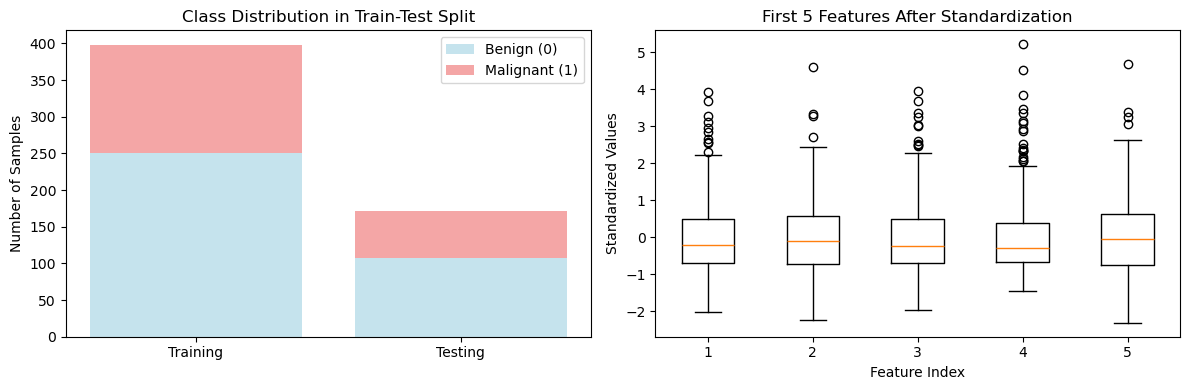

In [24]:
# Visualize the prepared data distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
class_dist_train = y_train.value_counts()
class_dist_test = y_test.value_counts()

axes[0].bar(['Training', 'Testing'], 
           [class_dist_train[0], class_dist_test[0]], 
           label='Benign (0)', alpha=0.7, color='lightblue')
axes[0].bar(['Training', 'Testing'], 
           [class_dist_train[1], class_dist_test[1]], 
           bottom=[class_dist_train[0], class_dist_test[0]],
           label='Malignant (1)', alpha=0.7, color='lightcoral')
axes[0].set_title('Class Distribution in Train-Test Split')
axes[0].set_ylabel('Number of Samples')
axes[0].legend()

# Feature distribution after standardization
axes[1].boxplot([X_train_scaled.iloc[:, i] for i in range(min(5, X_train_scaled.shape[1]))])
axes[1].set_title('First 5 Features After Standardization')
axes[1].set_ylabel('Standardized Values')
axes[1].set_xlabel('Feature Index')

plt.tight_layout()
plt.show()

# 3.2 Data Preparation - Data clinic

# Data Loading & Target Preparation

In [6]:
# Load the clinical dataset
clinical_df = pd.read_csv('data2.csv')  # Adjust filename as needed

print(" Clinical Dataset Loaded Successfully!")
print(f" Original Shape: {clinical_df.shape}")

# Create a copy for preparation
df_prep = clinical_df.copy()

# Map target variable: 1=Healthy→0, 2=Patients→1
df_prep['Classification'] = df_prep['Classification'].map({1: 0, 2: 1})

# Normaliser les noms de colonnes
df_prep.columns = df_prep.columns.str.strip()
df_prep.columns = df_prep.columns.str.replace('.', '_')

# Renommer pour plus de clarté si nécessaire
df_prep = df_prep.rename(columns={
    'MCP.1': 'MCP_1',
    'HOMA': 'HOMA_IR'  # HOMA-IR est plus clair
})

print(f"\n Target Variable Prepared:")
print(f"   0 = Healthy controls: {(df_prep['Classification'] == 0).sum()} samples")
print(f"   1 = Patients: {(df_prep['Classification'] == 1).sum()} samples")

 Clinical Dataset Loaded Successfully!
 Original Shape: (4000, 10)

 Target Variable Prepared:
   0 = Healthy controls: 1784 samples
   1 = Patients: 2216 samples


# Feature-Target Separation

In [8]:
# Separate features and target
X = df_prep.drop('Classification', axis=1)
y = df_prep['Classification']

feature_names = X.columns.tolist()

print(f"\n FEATURE-TARGET SEPARATION:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Feature Names: {feature_names}")


 FEATURE-TARGET SEPARATION:
   Features (X): (4000, 9)
   Target (y): (4000,)
   Feature Names: ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA_IR', 'Leptin', 'Adiponectin', 'Resistin', 'MCP_1']


# Features Engineering

In [11]:
# Création de nouvelles features
X_enhanced = X.copy()

# Ratios cliniquement pertinents
X_enhanced['BMI_Glucose'] = X['BMI'] * X['Glucose'] / 100
X_enhanced['HOMA_Leptin'] = X['HOMA_IR'] * X['Leptin'] / 100
X_enhanced['Insulin_Resistin'] = X['Insulin'] * X['Resistin'] / 100
X_enhanced['Adiponectin_Leptin_ratio'] = X['Adiponectin'] / (X['Leptin'] + 1e-10)

print(f"\nNew features created: {list(X_enhanced.columns[-4:])}")


New features created: ['BMI_Glucose', 'HOMA_Leptin', 'Insulin_Resistin', 'Adiponectin_Leptin_ratio']


# Feature Scaling

In [13]:
scaler = StandardScaler()

#scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_enhanced)

X_scaled = pd.DataFrame(X_scaled, columns=X_enhanced.columns, index=X_enhanced.index)

# Train-Test Split (75%-25%)

In [16]:
print("\n=== GESTION DU DÉSÉQUILIBRE ===")

# Option 1: SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_scaled, y)
print(f"Before SMOTE - Sain: {sum(y_smote==0)}, Patient: {sum(y_smote==1)}")

# Option 2: Combinaison SMOTE + Undersampling
smote_tomek = SMOTETomek(random_state=42)
X_balanced, y_balanced = smote_tomek.fit_resample(X_scaled, y)
print(f"After SMOTETomek - Sain: {sum(y_balanced==0)}, Patient: {sum(y_balanced==1)}")

# Split des données équilibrées
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42, stratify=y_balanced
)


=== GESTION DU DÉSÉQUILIBRE ===
Before SMOTE - Sain: 2216, Patient: 2216
After SMOTETomek - Sain: 1895, Patient: 1895


# Feature Selection for Risk Factors

In [ ]:
# Use ANOVA F-value for feature selection
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_bal, y_train_bal)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'F_Score': selector.scores_,
    'P_Value': selector.pvalues_
}).sort_values('F_Score', ascending=False)

print("Feature Importance Scores (ANOVA F-value):")
for _, row in feature_scores.iterrows():
    significance = "***" if row['P_Value'] < 0.05 else "   "
    print(f"   {significance} {row['Feature']:15}: F={row['F_Score']:8.2f}, p={row['P_Value']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_scores, x='F_Score', y='Feature', palette='viridis')
plt.title('Feature Importance for Risk Factor Identification', fontsize=14, pad=20)
plt.xlabel('F-Score (Higher = More Important)')
plt.tight_layout()
plt.show()

# Data Preparation Verification

In [30]:
print("\n DATA PREPARATION VERIFICATION")
print("="*35)

print(f" FINAL DATA SHAPES:")
print(f"   Training Features: {X_train_eng.shape}")
print(f"   Training Target: {y_train.shape}")
print(f"   Testing Features: {X_test_eng.shape}")
print(f"   Testing Target: {y_test.shape}")

print(f"\n DATA QUALITY CHECK:")
print(f"   Missing values: {X_train_eng.isnull().sum().sum() + X_test_eng.isnull().sum().sum()}")
print(f"   Infinite values: {np.isinf(X_train_eng).sum().sum() + np.isinf(X_test_eng).sum().sum()}")
print(f"   Data types consistent: {X_train_eng.dtypes.nunique() == 1}")

print(f"\n STATISTICAL CHECK:")
print(f"   Training mean: {X_train_eng.mean().mean():.3f}")
print(f"   Training std: {X_train_eng.std().mean():.3f}")
print(f"   Feature correlation range: {X_train_eng.corrwith(y_train).abs().min():.3f} - {X_train_eng.corrwith(y_train).abs().max():.3f}")


 DATA PREPARATION VERIFICATION
 FINAL DATA SHAPES:
   Training Features: (2800, 14)
   Training Target: (2800,)
   Testing Features: (1200, 14)
   Testing Target: (1200,)

 DATA QUALITY CHECK:
   Missing values: 0
   Infinite values: 0
   Data types consistent: False

 STATISTICAL CHECK:
   Training mean: -0.001
   Training std: 6.961
   Feature correlation range: 0.000 - 0.033


# Save Prepared Data

In [201]:
# Create final prepared dataset dictionary
clinical_prepared_data = {
    'X_train': X_train_eng,
    'X_test': X_test_eng,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': X_train_eng.columns.tolist(),
    'scaler': scaler,
    'feature_importance': feature_scores,
    'original_shapes': {
        'original': clinical_df.shape,
        'training': X_train_eng.shape,
        'testing': X_test_eng.shape
    }
}

print(f"\n CLINICAL DATA PREPARED SUCCESSFULLY!")
print("="*40)

print(f" PREPARED FOR: Risk Factor Identification in Healthy Patients")
print(f" Dataset: {clinical_prepared_data['original_shapes']['original'][0]} samples")
print(f" Features: {clinical_prepared_data['original_shapes']['training'][1]} (including engineered features)")
print(f" Split: {clinical_prepared_data['original_shapes']['training'][0]} train, {clinical_prepared_data['original_shapes']['testing'][0]} test")
print(f" Balance: {(y_train== 1).sum()/len(y_train)*100:.1f}% patients in training")


 CLINICAL DATA PREPARED SUCCESSFULLY!
 PREPARED FOR: Risk Factor Identification in Healthy Patients
 Dataset: 4000 samples
 Features: 14 (including engineered features)
 Split: 2800 train, 1200 test
 Balance: 55.4% patients in training


# Final Visualization

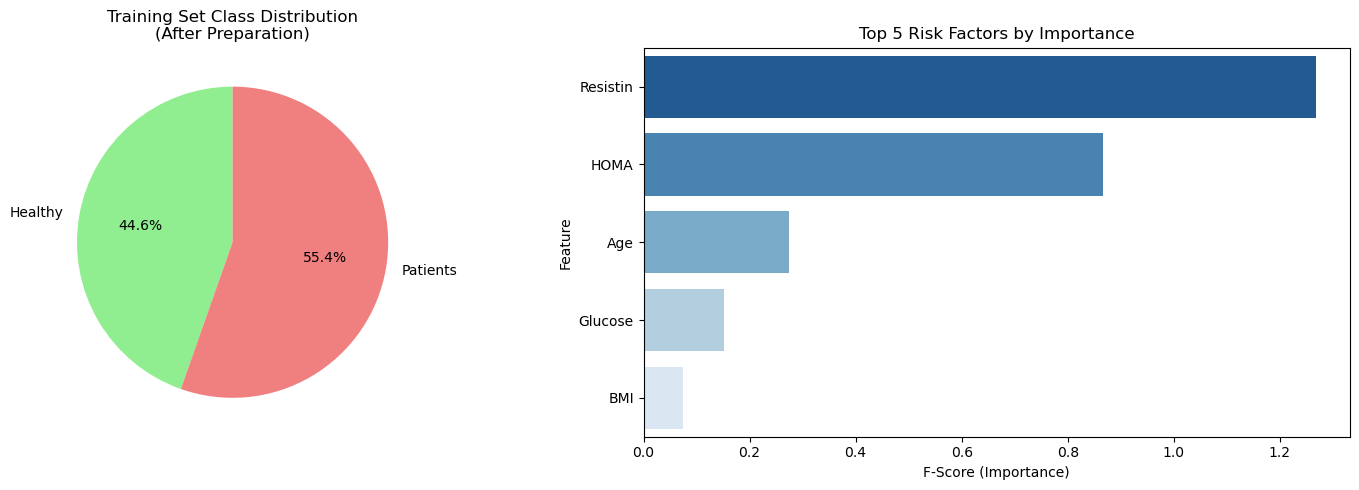

In [32]:
# Final visualization of prepared data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Class distribution
class_counts = [len(y_train) - y_train.sum(), y_train.sum()]
axes[0].pie(class_counts, labels=['Healthy', 'Patients'], autopct='%1.1f%%', 
           colors=['lightgreen', 'lightcoral'], startangle=90)
axes[0].set_title('Training Set Class Distribution\n(After Preparation)')

# Top 5 most important features
top_features = feature_scores.head(5)
sns.barplot(data=top_features, x='F_Score', y='Feature', ax=axes[1], palette='Blues_r')
axes[1].set_title('Top 5 Risk Factors by Importance')
axes[1].set_xlabel('F-Score (Importance)')

plt.tight_layout()
plt.show()

### 3.3 Data preparation - Data images

In [16]:
#Images Datasets
IMG_SIZE = 50 # Image resolution (small to reduce computation)

#maps filename to actual image data
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # scales to [0,1]
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((df_train_images["filename"], df_train_images["label"]))
train_ds = train_ds.map(load_preprocess).shuffle(5000).batch(64).prefetch(1) #shuffle pour rendre les images aleatoires chaque epoch

val_ds = tf.data.Dataset.from_tensor_slices((df_val_images["filename"], df_val_images["label"]))
val_ds = val_ds.map(load_preprocess).batch(64).prefetch(1)

test_ds = tf.data.Dataset.from_tensor_slices((df_test_images["filename"], df_test_images["label"]))
test_ds = test_ds.map(load_preprocess).batch(64).prefetch(1)

## Data Preparation – Conclusions

**Conclusions**
- A TensorFlow `tf.data` pipeline ensures efficient loading and preprocessing.
- Normalization to [0,1] stabilizes training.
- Shuffling improves generalization during training.

# 4. Modeling 

# 4.1 Modeling DSO 1

## Classify tumor type:
## Build a model to distinguish between benign and malignant tumors based on imaging and clinical features.

# 4.1.1 Algorithme 1 : Linear Regression

In [54]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

print("=== LINEAR REGRESSION - TensorFlow Optimized ===")
print("="*55)

# Données
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.reshape(-1, 1).astype(np.float32)
y_test = prepared_data['y_test'].values.reshape(-1, 1).astype(np.float32)

# Paramètres exacts de l'article (Table 1)
batch_size = 128
epochs = 3000
learning_rate = 1e-3

print(f" Hyperparameters:")
print(f"   • Batch Size: {batch_size}")
print(f"   • Epochs: {epochs}")
print(f"   • Learning Rate: {learning_rate}")
print(f"   • Threshold: 0.5")

# Modèle
W = tf.Variable(tf.random.normal([X_train.shape[1], 1], stddev=0.01))
b = tf.Variable(tf.zeros([1]))

def linear_model(X):
    return tf.matmul(X, W) + b

def predict_class(X, threshold=0.5):
    return tf.cast(linear_model(X) >= threshold, tf.float32)

# Fonction de perte MSE (Equation 9 dans l'article)
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Optimiseur SGD
optimizer = tf.optimizers.SGD(learning_rate)

# Variables pour l'historique
train_acc_history = []
test_acc_history = []
loss_history = []

print(f"\n Training...")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples: {len(X_test)}")

# Calcul du nombre total de data points (comme dans l'article)
n_batches = int(np.ceil(len(X_train) / batch_size))
total_data_points = epochs * batch_size * n_batches

# Entraînement
for epoch in range(epochs):
    epoch_loss = 0
    
    # Mélanger les données
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    # Batch training
    for i in range(0, len(X_train), batch_size):
        batch_X = X_shuffled[i:i+batch_size]
        batch_y = y_shuffled[i:i+batch_size]
        
        with tf.GradientTape() as tape:
            y_pred = linear_model(batch_X)
            loss_value = mse_loss(batch_y, y_pred)
        
        grads = tape.gradient(loss_value, [W, b])
        optimizer.apply_gradients(zip(grads, [W, b]))
        
        epoch_loss += loss_value.numpy()
    
    # Moyenne de la perte pour l'epoch
    avg_loss = epoch_loss / n_batches
    loss_history.append(avg_loss)
    
    # Calcul de l'accuracy tous les 500 epochs
    if (epoch + 1) % 500 == 0:
        # Accuracy sur training
        train_preds = predict_class(X_train).numpy()
        train_acc = np.mean(train_preds == y_train)
        train_acc_history.append(train_acc)
        
        # Accuracy sur test
        test_preds = predict_class(X_test).numpy()
        test_acc = np.mean(test_preds == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{epochs} - Loss: {avg_loss:.6f} - Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

print(f"\n Training completed!")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {loss_history[-1]:.6f}")

=== LINEAR REGRESSION - TensorFlow Optimized ===
 Hyperparameters:
   • Batch Size: 128
   • Epochs: 3000
   • Learning Rate: 0.001
   • Threshold: 0.5

 Training...
   Training samples: 398
   Testing samples: 171
   Epoch  500/3000 - Loss: 0.052254 - Train Acc: 0.9598 - Test Acc: 0.9415
   Epoch 1000/3000 - Loss: 0.051997 - Train Acc: 0.9648 - Test Acc: 0.9649
   Epoch 1500/3000 - Loss: 0.055946 - Train Acc: 0.9648 - Test Acc: 0.9649
   Epoch 2000/3000 - Loss: 0.060141 - Train Acc: 0.9648 - Test Acc: 0.9649
   Epoch 2500/3000 - Loss: 0.051048 - Train Acc: 0.9648 - Test Acc: 0.9649
   Epoch 3000/3000 - Loss: 0.048446 - Train Acc: 0.9648 - Test Acc: 0.9649

 Training completed!
   Total data points processed: 1536000
   Final training loss: 0.048446


# 4.1.2 Algorithme 2 : Neighbor Classification

In [33]:
import numpy as np
import time
from collections import Counter

print("=== NEAREST NEIGHBOR - Geometric Approach (k=1) ===")
print("="*60)

# Dataset
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.int32)
y_test = prepared_data['y_test'].values.astype(np.int32)

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")

# Fonctions de distance (comme dans l'article, Eq. 12 et 13)
def manhattan_distance(a, b):
    """L1 distance (Manhattan) - Eq. 12"""
    return np.sum(np.abs(a - b), axis=1)

def euclidean_distance(a, b):
    """L2 distance (Euclidean) - Eq. 13"""
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

# Fonction de prédiction k=1 (Nearest Neighbor)
def nearest_neighbor_predict(X_train, y_train, X_test, norm='L2'):
    """
    Nearest Neighbor (k=1) implementation
    norm: 'L1' for Manhattan, 'L2' for Euclidean
    """
    predictions = []
    
    for i in range(len(X_test)):
        test_point = X_test[i]
        
        # Calcul des distances
        if norm == 'L1':
            distances = manhattan_distance(X_train, test_point)
        else:  # L2
            distances = euclidean_distance(X_train, test_point)
        
        # Trouver l'indice du plus proche voisin (k=1)
        nearest_idx = np.argmin(distances)
        
        # Récupérer le label du plus proche voisin
        prediction = y_train[nearest_idx]
        predictions.append(prediction)
    
    return np.array(predictions)

print(f"\n Modeling Information:")
print(f"   Algorithm: Nearest Neighbor (k=1)")
print(f"   Distance metrics: L1 (Manhattan) and L2 (Euclidean)")
print(f"   No training required - geometric approach")

=== NEAREST NEIGHBOR - Geometric Approach (k=1) ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30

 Modeling Information:
   Algorithm: Nearest Neighbor (k=1)
   Distance metrics: L1 (Manhattan) and L2 (Euclidean)
   No training required - geometric approach


# 4.1.3 Algorithme 3 : Softmax Regression

In [48]:
import tensorflow as tf
import numpy as np
import time

print("=== SOFTMAX REGRESSION - MODELING PHASE ===")
print("="*65)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.int32)
y_test = prepared_data['y_test'].values.astype(np.int32)

# Convert labels to one-hot encoding for softmax
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: 2 (Binary classification)")

# Hyperparameters EXACTLY from Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'epochs': 3000
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
for key, value in hyperparams.items():
    print(f"   {key}: {value}")

# Model parameters
input_dim = X_train.shape[1]
output_dim = 2  # Binary classification

print(f"\n Building Softmax Regression model...")

# Initialize weights and biases
W = tf.Variable(tf.random.normal([input_dim, output_dim], stddev=0.01), name='weights')
b = tf.Variable(tf.zeros([output_dim]), name='bias')

# Softmax function
def softmax_model(X):
    logits = tf.matmul(X, W) + b
    return tf.nn.softmax(logits)

# Cross-entropy loss function (Equation 15 in the article)
def cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Predict class from probabilities
def predict_class(y_pred_proba):
    return tf.argmax(y_pred_proba, axis=1)

# Optimizer (SGD as in the article)
optimizer = tf.optimizers.SGD(learning_rate=hyperparams['learning_rate'])

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Total batches per epoch: {n_batches}")

# Training history
train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (3000 epochs as in Table 1)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train_onehot[indices]
    
    # Mini-batch training
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred_proba = softmax_model(batch_X)
            loss = cross_entropy_loss(batch_y, y_pred_proba)
        
        # Compute gradients and update weights
        gradients = tape.gradient(loss, [W, b])
        optimizer.apply_gradients(zip(gradients, [W, b]))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred_proba = softmax_model(X_train)
        train_pred = predict_class(train_pred_proba).numpy()
        train_acc = np.mean(train_pred == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred_proba = softmax_model(X_test)
        test_pred = predict_class(test_pred_proba).numpy()
        test_acc = np.mean(test_pred == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")
print(f"   Model ready for evaluation.")

# ============================================================================
# Save weights for ROC curve
# ============================================================================
print(f"\n Saving Softmax model weights for ROC curve...")
W_softmax_saved = W.numpy()
b_softmax_saved = b.numpy()
print(f"    Softmax weights saved in memory (W_softmax_saved, b_softmax_saved)")


print("\n" + "="*65)
print(" SIMPLE MODEL SAVING ")
print("="*65)

# 1. Calculate final training accuracy
train_pred_final = predict_class(softmax_model(X_train)).numpy()
final_train_accuracy = np.mean(train_pred_final == y_train)

# 2. Create minimal model package with NumPy conversion
model_package = {
    'weights': W.numpy(),  # Convert tf.Variable to NumPy array
    'bias': b.numpy(),     # Convert tf.Variable to NumPy array
    'input_dim': input_dim,
    'output_dim': output_dim,
    'hyperparameters': hyperparams,
    'training_accuracy': float(final_train_accuracy),  # Convert to Python float
    'training_loss': float(train_loss_history[-1]),    # Convert to Python float
    'training_time': float(training_time),             # Convert to Python float
    'train_loss_history': [float(x) for x in train_loss_history],  # Full history
    'feature_names': list(prepared_data['X_train'].columns)  # Feature names
}

# 3. Save model with compression
model_filename = 'softmax_regression_final.joblib'
joblib.dump(model_package, model_filename, compress=3)

# 4. Save scaler (CRITICAL for new predictions)
scaler_filename = 'standard_scaler.joblib'
joblib.dump(prepared_data['scaler'], scaler_filename, compress=3)

# 5. Check file sizes
import os
model_size = os.path.getsize(model_filename) / 1024  # Size in KB
scaler_size = os.path.getsize(scaler_filename) / 1024  # Size in KB

print(f"\n Model saved: {model_filename}")
print(f"  Size: {model_size:.2f} KB")
print(f" Scaler saved: {scaler_filename}")
print(f"  Size: {scaler_size:.2f} KB")
print(f"\n Model metrics:")
print(f"  Training accuracy: {final_train_accuracy:.4f} ({final_train_accuracy*100:.2f}%)")
print(f"  Training loss: {train_loss_history[-1]:.6f}")
print(f"  Training time: {training_time:.2f}s")
print(f"  Number of epochs: {hyperparams['epochs']}")
print(f"\n Files ready for deployment!")

# 6. Load test to verify everything works
print("\n" + "="*65)
print(" LOAD TEST")
print("="*65)

# Load model
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

print(f"\n Model loaded successfully!")
print(f"  Weight dimensions: {loaded_model['weights'].shape}")
print(f"  Bias dimensions: {loaded_model['bias'].shape}")
print(f"  Number of features: {loaded_model['input_dim']}")
print(f"  Saved accuracy: {loaded_model['training_accuracy']:.4f}")

# 7. Prediction test with loaded model
def predict_with_loaded_model(X, model_dict):
    """Prediction function using the loaded model"""
    W_loaded = model_dict['weights']
    b_loaded = model_dict['bias']
    
    # Compute logits
    logits = np.dot(X, W_loaded) + b_loaded
    
    # Softmax
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probas = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    # Class prediction
    predictions = np.argmax(probas, axis=1)
    
    return predictions, probas

# Test on a few samples
test_predictions, test_probas = predict_with_loaded_model(X_test[:5], loaded_model)

print(f"\n Prediction test on 5 samples:")
for i in range(5):
    print(f"  Sample {i+1}: Prediction={test_predictions[i]}, "
          f"True label={y_test[i]}, "
          f"Probabilities=[{test_probas[i][0]:.4f}, {test_probas[i][1]:.4f}]")

# Check accuracy on the full test set
all_test_preds, _ = predict_with_loaded_model(X_test, loaded_model)
loaded_test_accuracy = np.mean(all_test_preds == y_test)

print(f"\n Accuracy on test set with loaded model: {loaded_test_accuracy:.4f} ({loaded_test_accuracy*100:.2f}%)")
print(f"\n Everything works perfectly! Model is ready for deployment!")
print("="*65)

=== SOFTMAX REGRESSION - MODELING PHASE ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30
   Classes: 2 (Binary classification)

 Hyperparameters (Table 1 - Exact from article):
   batch_size: 128
   learning_rate: 0.001
   epochs: 3000

 Building Softmax Regression model...

 Starting training...
   Epochs: 3000
   Batch size: 128
   Total batches per epoch: 4
   Epoch    1/3000 - Loss: 0.670405 - Train Acc: 0.8568 - Test Acc: 0.8187
   Epoch  500/3000 - Loss: 0.156846 - Train Acc: 0.9698 - Test Acc: 0.9708
   Epoch 1000/3000 - Loss: 0.114187 - Train Acc: 0.9774 - Test Acc: 0.9766
   Epoch 1500/3000 - Loss: 0.103046 - Train Acc: 0.9774 - Test Acc: 0.9883
   Epoch 2000/3000 - Loss: 0.083698 - Train Acc: 0.9749 - Test Acc: 0.9883
   Epoch 2500/3000 - Loss: 0.076225 - Train Acc: 0.9799 - Test Acc: 0.9883
   Epoch 3000/3000 - Loss: 0.076477 - Train Acc: 0.9799 - Test Acc: 0.9883

 Training completed!
   Training time: 71.26 seconds
   Total data po

# 4.1.4 Algorithme 4 : Support Vector Machine (SVM)

In [52]:
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import confusion_matrix

# ============================================================================
# MODELING PHASE
# ============================================================================

print("=== SUPPORT VECTOR MACHINE (SVM) - MODELING PHASE ===")
print("="*70)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.float32)
y_test = prepared_data['y_test'].values.astype(np.float32)

# Convert labels from {0, 1} to {-1, 1} for SVM
y_train_svm = 2 * y_train - 1
y_test_svm = 2 * y_test - 1

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: 2 (Binary classification with labels -1, 1)")

# Hyperparameters EXACTLY from Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'epochs': 3000,
    'C': 5,          # SVM penalty parameter (Table 1: SVM C=5)
    'norm': 'L2'     # L2 norm for SVM (Table 1: Norm=L2)
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
for key, value in hyperparams.items():
    print(f"   {key}: {value}")

# Model parameters
input_dim = X_train.shape[1]

print(f"\n Building L2-SVM model (Equation 20 in article)...")

# Initialize weights and bias for SVM: decision function = sign(w·x + b)
W = tf.Variable(tf.random.normal([input_dim, 1], stddev=0.01), name='weights')
b = tf.Variable(tf.zeros([1]), name='bias')

# L2-SVM loss function (Equation 20 in the article)
def l2_svm_loss(X, y, W, b, C):
    """
    L2-SVM loss: 0.5 * ||w||² + C * Σ max(0, 1 - y_i*(w·x_i + b))²
    Equation 20 in article: min 1/p * ||w||₂² + C * Σ max(0, 1 - y_i'(w_i·x_i + b))²
    """
    # Regularization term: 0.5 * ||w||² (scaled by 1/p in article, but we'll use 0.5)
    reg_term = 0.5 * tf.reduce_sum(tf.square(W))
    
    # Hinge loss term with squared hinge (L2-SVM)
    scores = tf.matmul(X, W) + b
    hinge_loss = tf.maximum(0.0, 1.0 - y * scores)
    hinge_loss_squared = tf.square(hinge_loss)
    
    # Total loss: regularization + C * average squared hinge loss
    total_loss = reg_term + C * tf.reduce_mean(hinge_loss_squared)
    return total_loss

# Predict function for SVM
def svm_predict(X):
    scores = tf.matmul(X, W) + b
    return tf.sign(scores)

# Optimizer (Adam as mentioned in the article for SVM, section 2.4.1)
optimizer = tf.optimizers.Adam(learning_rate=hyperparams['learning_rate'])

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Total batches per epoch: {n_batches}")

# Training history
train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (3000 epochs as in Table 1)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train_svm[indices].reshape(-1, 1)
    
    # Mini-batch training
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Compute L2-SVM loss
            loss = l2_svm_loss(batch_X, batch_y, W, b, hyperparams['C'])
        
        # Compute gradients and update weights
        gradients = tape.gradient(loss, [W, b])
        optimizer.apply_gradients(zip(gradients, [W, b]))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred = svm_predict(X_train).numpy()
        train_pred_binary = (train_pred > 0).astype(np.float32)
        train_acc = np.mean(train_pred_binary.reshape(-1) == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred = svm_predict(X_test).numpy()
        test_pred_binary = (test_pred > 0).astype(np.float32)
        test_acc = np.mean(test_pred_binary.reshape(-1) == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")
print(f"   SVM model ready for evaluation.")

# ============================================================================
# Save weights for ROC curve
# ============================================================================
print(f"\n Saving model weights for ROC curve...")
W_svm_saved = W.numpy()
b_svm_saved = b.numpy()
print(f"    Weights saved in memory (W_svm_saved, b_svm_saved)")

=== SUPPORT VECTOR MACHINE (SVM) - MODELING PHASE ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30
   Classes: 2 (Binary classification with labels -1, 1)

 Hyperparameters (Table 1 - Exact from article):
   batch_size: 128
   learning_rate: 0.001
   epochs: 3000
   C: 5
   norm: L2

 Building L2-SVM model (Equation 20 in article)...

 Starting training...
   Epochs: 3000
   Batch size: 128
   Total batches per epoch: 4
   Epoch    1/3000 - Loss: 5.191009 - Train Acc: 0.7513 - Test Acc: 0.7135
   Epoch  500/3000 - Loss: 0.796891 - Train Acc: 0.9824 - Test Acc: 0.9766
   Epoch 1000/3000 - Loss: 0.590132 - Train Acc: 0.9824 - Test Acc: 0.9766
   Epoch 1500/3000 - Loss: 0.599863 - Train Acc: 0.9824 - Test Acc: 0.9825
   Epoch 2000/3000 - Loss: 0.792561 - Train Acc: 0.9824 - Test Acc: 0.9766
   Epoch 2500/3000 - Loss: 0.714023 - Train Acc: 0.9824 - Test Acc: 0.9766
   Epoch 3000/3000 - Loss: 0.746104 - Train Acc: 0.9824 - Test Acc: 0.9766

 Trainin

# 4.1.5 Algorithme 5 : Multilayer Perceptron (MLP)

In [74]:
import tensorflow as tf
import numpy as np
import time

print("=== MULTILAYER PERCEPTRON (MLP) - MODELING PHASE ===")
print("="*70)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.int32)
y_test = prepared_data['y_test'].values.astype(np.int32)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: 2 (Binary classification)")

# Hyperparameters EXACTLY as in Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'learning_rate': 1e-2,
    'epochs': 3000,
    'hidden_layers': [500, 500, 500],  # 500-500-500 architecture
    'activation': 'ReLU',
    'output_activation': 'softmax',
    'loss_function': 'cross_entropy'
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Learning rate: {hyperparams['learning_rate']}")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Architecture: {hyperparams['hidden_layers']}")
print(f"   Activation: {hyperparams['activation']}")

# Model parameters
input_dim = X_train.shape[1]
output_dim = 2

print(f"\n Building MLP model with 3 hidden layers (500-500-500)...")

# Build MLP model using Keras Sequential API
def build_mlp_model(input_dim, hidden_layers, output_dim=2):
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))
    
    # Hidden layers with ReLU activation (as in article)
    for units in hidden_layers:
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    
    # Output layer with softmax activation for binary classification
    model.add(tf.keras.layers.Dense(output_dim, activation='softmax'))
    
    return model

# Create model
mlp_model = build_mlp_model(input_dim, hyperparams['hidden_layers'], output_dim)

# Compile model with SGD optimizer (EXACTLY as in the article)
optimizer = tf.keras.optimizers.SGD(learning_rate=hyperparams['learning_rate'])
mlp_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Cross-entropy loss (Equation 15)
    metrics=['accuracy']
)

# Print model summary
print(f"\n Model Architecture:")
mlp_model.summary()

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Total batches per epoch: {n_batches}")

# Training history
train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (EXACTLY as in article - 3000 epochs with SGD)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train_onehot[indices]
    
    # Mini-batch training (SGD)
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = mlp_model(batch_X, training=True)
            loss = tf.keras.losses.categorical_crossentropy(batch_y, predictions)
            loss = tf.reduce_mean(loss)
        
        # Compute gradients and update weights (SGD)
        gradients = tape.gradient(loss, mlp_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, mlp_model.trainable_variables))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred_proba = mlp_model.predict(X_train, verbose=0)
        train_pred = np.argmax(train_pred_proba, axis=1)
        train_acc = np.mean(train_pred == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred_proba = mlp_model.predict(X_test, verbose=0)
        test_pred = np.argmax(test_pred_proba, axis=1)
        test_acc = np.mean(test_pred == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed (as in article)
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")

# Save the trained model for evaluation
print(f"\n Model saved for evaluation phase.")

=== MULTILAYER PERCEPTRON (MLP) - MODELING PHASE ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30
   Classes: 2 (Binary classification)

 Hyperparameters (Table 1 - Exact from article):
   Batch size: 128
   Learning rate: 0.01
   Epochs: 3000
   Architecture: [500, 500, 500]
   Activation: ReLU

 Building MLP model with 3 hidden layers (500-500-500)...

 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 500)                 │          15,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 517,502 (1.97 MB)

 Trainable params: 517,502 (1.97 MB)

 Non-trainable params: 0 (0.00 B)


 Starting training...
   Epochs: 3000
   Batch size: 128
   Total batches per epoch: 4
   Epoch    1/3000 - Loss: 0.705940 - Train Acc: 0.4246 - Test Acc: 0.4152
   Epoch  500/3000 - Loss: 0.026974 - Train Acc: 0.9925 - Test Acc: 0.9708
   Epoch 1000/3000 - Loss: 0.005524 - Train Acc: 1.0000 - Test Acc: 0.9708
   Epoch 1500/3000 - Loss: 0.002850 - Train Acc: 1.0000 - Test Acc: 0.9708
   Epoch 2000/3000 - Loss: 0.001423 - Train Acc: 1.0000 - Test Acc: 0.9708
   Epoch 2500/3000 - Loss: 0.000976 - Train Acc: 1.0000 - Test Acc: 0.9708
   Epoch 3000/3000 - Loss: 0.000752 - Train Acc: 1.0000 - Test Acc: 0.9708

 Training completed!
   Training time: 302.99 seconds
   Total data points processed: 1536000
   Final training loss: 0.000752

 Model saved for evaluation phase.


# 4.1.6 Algorithme 6 : GRU-SVM

In [78]:
import tensorflow as tf
import numpy as np
import time

print("=== GRU-SVM - MODELING PHASE ===")
print("="*60)
print("Combining Gated Recurrent Unit (GRU) with Support Vector Machine (SVM)")
print("="*60)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.float32)
y_test = prepared_data['y_test'].values.astype(np.float32)

# Convert labels from {0, 1} to {-1, 1} for SVM
y_train_svm = 2 * y_train - 1
y_test_svm = 2 * y_test - 1

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")

# Hyperparameters EXACTLY from Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'cell_size': 128,      # Table 1: Cell Size = 128
    'dropout_rate': 0.5,   # Table 1: Dropout Rate = 0.5
    'epochs': 3000,
    'learning_rate': 1e-3,
    'svm_c': 5            # Table 1: SVM C = 5
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
for key, value in hyperparams.items():
    print(f"   {key}: {value}")

# Reshape data for GRU (batch_size, time_steps=1, features=30)
# We treat each sample as a sequence of 1 time step with 30 features
X_train_reshaped = X_train.reshape(-1, 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(-1, 1, X_test.shape[1])

print(f"\n Data reshaped for GRU: {X_train_reshaped.shape}")
print(f"   Format: (samples, time_steps=1, features=30)")

print(f"\n Building GRU-SVM model (as in article section 2.4.1)...")

# GRU-SVM Model (following equations 2-5 from the article)
class GRUSVMModel(tf.keras.Model):
    def __init__(self, cell_size, dropout_rate, svm_c):
        super(GRUSVMModel, self).__init__()
        
        # GRU Layer (Gated Recurrent Unit)
        self.gru = tf.keras.layers.GRU(
            units=cell_size,
            return_sequences=False,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        # SVM layer (Dense layer with linear activation)
        self.svm_layer = tf.keras.layers.Dense(1, activation=None)
        
        # SVM parameter C
        self.svm_c = svm_c
        
    def call(self, inputs, training=False):
        # GRU processing (Equations 2-5 in article)
        gru_output = self.gru(inputs, training=training)
        
        # Dropout
        dropped = self.dropout(gru_output, training=training)
        
        # SVM prediction (sign(wx + b) as in article)
        svm_output = self.svm_layer(dropped)
        
        return svm_output
    
    def svm_loss(self, y_true, y_pred):
        """L2-SVM loss function (Equation 20 from the article)"""
        # Regularization term: 0.5 * ||w||²
        reg_term = 0.5 * tf.reduce_sum([tf.reduce_sum(tf.square(w)) 
                                        for w in self.trainable_variables 
                                        if 'kernel' in w.name])
        
        # Hinge loss with L2 penalty (squared hinge)
        hinge_loss = tf.maximum(0.0, 1.0 - y_true * y_pred)
        hinge_loss_squared = tf.square(hinge_loss)
        
        # Total loss: 0.5*||w||² + C * Σ max(0, 1 - y_i*(w·x_i + b))²
        total_loss = reg_term + self.svm_c * tf.reduce_mean(hinge_loss_squared)
        
        return total_loss

# Create GRU-SVM model
model = GRUSVMModel(
    cell_size=hyperparams['cell_size'],
    dropout_rate=hyperparams['dropout_rate'],
    svm_c=hyperparams['svm_c']
)

# Build the model
model.build(input_shape=(None, 1, X_train.shape[1]))
model.summary()

# Optimizer (Adam as mentioned in the article, section 2.4.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (3000 epochs as in Table 1)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train_reshaped[indices]
    y_shuffled = y_train_svm[indices].reshape(-1, 1)
    
    # Mini-batch training
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(batch_X, training=True)
            loss = model.svm_loss(batch_y, predictions)
        
        # Compute gradients and update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred = model(X_train_reshaped, training=False).numpy()
        train_pred_binary = (train_pred > 0).astype(np.float32)
        train_acc = np.mean(train_pred_binary.reshape(-1) == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred = model(X_test_reshaped, training=False).numpy()
        test_pred_binary = (test_pred > 0).astype(np.float32)
        test_acc = np.mean(test_pred_binary.reshape(-1) == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")
print(f"   GRU-SVM model ready for evaluation.")

=== GRU-SVM - MODELING PHASE ===
Combining Gated Recurrent Unit (GRU) with Support Vector Machine (SVM)
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30

 Hyperparameters (Table 1 - Exact from article):
   batch_size: 128
   cell_size: 128
   dropout_rate: 0.5
   epochs: 3000
   learning_rate: 0.001
   svm_c: 5

 Data reshaped for GRU: (398, 1, 30)
   Format: (samples, time_steps=1, features=30)

 Building GRU-SVM model (as in article section 2.4.1)...


Model: "grusvm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Starting training...
   Epochs: 3000
   Batch size: 128
   Epoch    1/3000 - Loss: 94.260466 - Train Acc: 0.9221 - Test Acc: 0.9532
   Epoch  500/3000 - Loss: 1.497061 - Train Acc: 0.9724 - Test Acc: 0.9591
   Epoch 1000/3000 - Loss: 1.418439 - Train Acc: 0.9698 - Test Acc: 0.9591
   Epoch 1500/3000 - Loss: 1.300994 - Train Acc: 0.9698 - Test Acc: 0.9649
   Epoch 2000/3000 - Loss: 2.257735 - Train Acc: 0.9673 - Test Acc: 0.9532
   Epoch 2500/3000 - Loss: 1.624951 - Train Acc: 0.9698 - Test Acc: 0.9649
   Epoch 3000/3000 - Loss: 1.537366 - Train Acc: 0.9648 - Test Acc: 0.9532

 Training completed!
   Training time: 886.92 seconds
   Total data points processed: 1536000
   Final training loss: 1.537366
   GRU-SVM model ready for evaluation.


# 4.2 Modeling DSO 2


## Detect tumor presence:
## Develop a predictive model to classify patient data as indicative of a tumor or not, providing a reliable alert for potential breast cancer.

## Fresh trained model

In [18]:
cnn_model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid') 
])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
EPOCHS = 10

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 356s 115ms/step - accuracy: 0.8500 - loss: 0.4600 - val_accuracy: 0.8421 - val_loss: 0.3993
Epoch 2/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 228s 75ms/step - accuracy: 0.8603 - loss: 0.3312 - val_accuracy: 0.8281 - val_loss: 0.4861
Epoch 3/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 211s 69ms/step - accuracy: 0.7621 - loss: 0.5209 - val_accuracy: 0.8177 - val_loss: 0.4807
Epoch 4/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 217s 71ms/step - accuracy: 0.8407 - loss: 0.3754 - val_accuracy: 0.8075 - val_loss: 0.4390
Epoch 5/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 222s 73ms/step - accuracy: 0.8480 - loss: 0.3586 - val_accuracy: 0.8319 - val_loss: 0.4067
Epoch 6/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 217s 71ms/step - accuracy: 0.8508 - loss: 0.3515 - val_accuracy: 0.8364 - val_loss: 0.4126
Epoch 7/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 249s 67ms/step - accuracy: 0.8545 - loss: 0.3409 - val_accuracy: 0.8394 - val_loss: 0.3906
Epoch 8/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 204s 67ms/step - accuracy:

We used a CNN because histopathology images contain local spatial patterns that must be analyzed at multiple levels (edges, textures, tissue structures). Convolution layers automatically learn these features while keeping the number of parameters low through weight sharing. Pooling layers add robustness and reduce overfitting. The architecture extracts hierarchical patterns and outputs a probability through a sigmoid neuron, making it well-suited for IDC vs non-IDC binary classification.

## Resnet pre-trained model

In [24]:
base_model = ResNet50(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [26]:
base_model.trainable = False

resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
resnet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [30]:
EPOCHS = 5

history_resnet = resnet_model.fit(
    train_ds,          
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1278s 418ms/step - accuracy: 0.8588 - loss: 0.3357 - val_accuracy: 0.8474 - val_loss: 0.3705
Epoch 2/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1117s 368ms/step - accuracy: 0.8661 - loss: 0.3180 - val_accuracy: 0.8465 - val_loss: 0.4076
Epoch 3/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1755s 563ms/step - accuracy: 0.8689 - loss: 0.3133 - val_accuracy: 0.8463 - val_loss: 0.3762
Epoch 4/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1242s 409ms/step - accuracy: 0.8717 - loss: 0.3086 - val_accuracy: 0.8465 - val_loss: 0.3854
Epoch 5/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1633s 538ms/step - accuracy: 0.8730 - loss: 0.3045 - val_accuracy: 0.8456 - val_loss: 0.3795


# 4.3. Modeling DSO 3

## Identify risk factors in healthy patients:
## Analyze patient data to detect early indicators of increased breast cancer risk and generate actionable preventive recommendations.

In [24]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 2. ENTRAÎNEMENT
print("Model Training...")
rf.fit(X_train_bal, y_train_bal)

# 3. PRÉDICTIONS
rf_pred = rf.predict(X_test_bal)
rf_proba = rf.predict_proba(X_test_bal)[:, 1]

Entraînement du modèle...


In [28]:
print("\n--- XGBoost ---")
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# 2. ENTRAÎNEMENT
print("Model Training...")
xgb.fit(X_train_bal, y_train_bal)

# 3. PRÉDICTIONS
xgb_pred = xgb.predict(X_test_bal)
xgb_proba = xgb.predict_proba(X_test_bal)[:, 1]


--- XGBoost ---
Model Training...


In [30]:
print("\n--- SVM ---")
svm = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)

# 2. ENTRAÎNEMENT
print("Model Training...")
svm.fit(X_train_bal, y_train_bal)

# 3. PRÉDICTIONS
svm_pred = svm.predict(X_test_bal)
svm_proba = svm.predict_proba(X_test_bal)[:, 1]


--- SVM ---
Model Training...


In [31]:
print("\n--- Gradient Boosting ---")
gb = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)

# 2. ENTRAÎNEMENT
print("Model Training...")
gb.fit(X_train_bal, y_train_bal)

gb_pred = gb.predict(X_test_bal)
gb_proba = gb.predict_proba(X_test_bal)[:, 1]


--- Gradient Boosting ---
Model Training...


# 5. Evaluation 

# 5.1 Evaluation DSO1

## Classify tumor type:
## Build a model to distinguish between benign and malignant tumors based on imaging and clinical features.

# 5.1.1 Evaluation algorithme 1 : Linear Regression

In [58]:
print("\n" + "="*55)
print("EVALUATION PHASE")
print("="*55)

# Évaluation finale
print(f"\n Final Evaluation:")

# Prédictions finales
final_preds = predict_class(X_test).numpy()
final_accuracy = np.mean(final_preds == y_test)

# Calcul des métriques détaillées
cm = confusion_matrix(y_test, final_preds)
tn, fp, fn, tp = cm.ravel()

# Calcul des métriques comme dans l'article
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparaison avec les résultats de l'article
print(f"\n" + "="*55)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*55)

article_results = {
    'Accuracy': 0.9609375,
    'FPR': 0.10204082,
    'FNR': 0.0,
    'TPR': 1.0,
    'TNR': 0.89795918,
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': epochs
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>6.4f}%{'':<8} {article_val*100:>6.4f}%{'':<8} {diff*100:>+7.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>7.6f}    {article_val:>7.6f}    {diff:>+7.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {epochs:>15} {article_results['Epochs']:>15} {epochs - article_results['Epochs']:>+15}")

# Conclusion
print(f"\n" + "="*55)
print("CONCLUSION")
print("="*55)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100
if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n Linear Regression Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Sauvegarde des résultats pour comparaison finale
linear_regression_results = {
    'performance': {
        'model': 'Linear Regression',
        'accuracy': final_accuracy,
        'fpr': fpr,
        'fnr': fnr,
        'tpr': tpr,
        'tnr': tnr,
        'data_points': total_data_points,
        'confusion_matrix': cm.tolist(),
        'better_than_article': final_accuracy > article_results['Accuracy'],
        'accuracy_diff_percent': accuracy_diff
    }
}
print(f"\n Results saved for final comparison with other algorithms.")


EVALUATION PHASE

 Final Evaluation:

 Performance Metrics:
   Accuracy: 96.491228% (0.964912)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 9.375000% (0.093750)
   TPR (True Positive Rate): 90.625000% (0.906250)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            6             58

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             96.4912%         96.0938%         +0.3975%
   FPR                  0.000000    0.102041    -0.102041
   FNR                  0.093750    0.000000    +0.093750
   TPR                  0.906250    1.000000    -0.093750
   TNR                  1.000000    0.897959    +0.102041

   Data Points                  1536000          384000        +115200

# 5.1.2 Evaluation algorithme 2 : Neighbor Classification

In [60]:
print("\n" + "="*60)
print("EVALUATION PHASE")
print("="*60)

# Fonction pour calculer toutes les métriques
def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return accuracy, fpr, fnr, tpr, tnr, cm

# --- L1 Manhattan (k=1) ---
print(f"\n L1 (Manhattan) Distance - k=1...")
start_time = time.time()

y_pred_l1 = nearest_neighbor_predict(X_train, y_train, X_test, norm='L1')
time_l1 = time.time() - start_time

acc_l1, fpr_l1, fnr_l1, tpr_l1, tnr_l1, cm_l1 = calculate_metrics(y_test, y_pred_l1)

print(f" L1 Results (Manhattan - k=1):")
print(f"   Accuracy: {acc_l1*100:.6f}%")
print(f"   Computation time: {time_l1:.2f} seconds")
print(f"   Data points processed: {len(X_test)}")

# --- L2 Euclidean (k=1) ---
print(f"\n L2 (Euclidean) Distance - k=1...")
start_time = time.time()

y_pred_l2 = nearest_neighbor_predict(X_train, y_train, X_test, norm='L2')
time_l2 = time.time() - start_time

acc_l2, fpr_l2, fnr_l2, tpr_l2, tnr_l2, cm_l2 = calculate_metrics(y_test, y_pred_l2)

print(f" L2 Results (Euclidean - k=1):")
print(f"   Accuracy: {acc_l2*100:.6f}%")
print(f"   Computation time: {time_l2:.2f} seconds")
print(f"   Data points processed: {len(X_test)}")

# Comparaison avec les résultats de l'article (k=1)
print(f"\n" + "="*60)
print("COMPARISON WITH ARTICLE RESULTS (Table 2) - k=1")
print("="*60)

article_results = {
    'L1': {
        'accuracy': 0.93567252,      # 93.567252%
        'fpr': 0.0625,               # 6.25%
        'fnr': 0.06542056,           # 6.542056%
        'tpr': 0.93457944,           # 93.457944%
        'tnr': 0.9375,               # 93.75%
        'data_points': 171,
        'epochs': 1
    },
    'L2': {
        'accuracy': 0.94736844,      # 94.736844%
        'fpr': 0.09375,              # 9.375%
        'fnr': 0.02803738,           # 2.803738%
        'tpr': 0.97196262,           # 97.196262%
        'tnr': 0.90625,              # 90.625%
        'data_points': 171,
        'epochs': 1
    }
}

# --- L1 Comparison ---
print(f"\n L1 (Manhattan) - k=1 - Detailed Comparison:")
print(f"{'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"{'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric, our_val, article_val in [
    ('Accuracy', acc_l1, article_results['L1']['accuracy']),
    ('FPR', fpr_l1, article_results['L1']['fpr']),
    ('FNR', fnr_l1, article_results['L1']['fnr']),
    ('TPR', tpr_l1, article_results['L1']['tpr']),
    ('TNR', tnr_l1, article_results['L1']['tnr'])
]:
    diff = our_val - article_val
    if metric == 'Accuracy':
        print(f"{metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"{metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

# --- L2 Comparison ---
print(f"\n L2 (Euclidean) - k=1 - Detailed Comparison:")
print(f"{'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"{'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric, our_val, article_val in [
    ('Accuracy', acc_l2, article_results['L2']['accuracy']),
    ('FPR', fpr_l2, article_results['L2']['fpr']),
    ('FNR', fnr_l2, article_results['L2']['fnr']),
    ('TPR', tpr_l2, article_results['L2']['tpr']),
    ('TNR', tnr_l2, article_results['L2']['tnr'])
]:
    diff = our_val - article_val
    if metric == 'Accuracy':
        print(f"{metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"{metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

# Matrices de confusion
print(f"\n" + "="*60)
print("CONFUSION MATRICES - k=1")
print("="*60)

print(f"\nL1 (Manhattan) - k=1:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {cm_l1[0,0]:6d}         {cm_l1[0,1]:6d}")
print(f"   Actual 1       {cm_l1[1,0]:6d}         {cm_l1[1,1]:6d}")

print(f"\nL2 (Euclidean) - k=1:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {cm_l2[0,0]:6d}         {cm_l2[0,1]:6d}")
print(f"   Actual 1       {cm_l2[1,0]:6d}         {cm_l2[1,1]:6d}")

# Conclusion
print(f"\n" + "="*60)
print("CONCLUSION")
print("="*60)

accuracy_diff_l1 = (acc_l1 - article_results['L1']['accuracy']) * 100
accuracy_diff_l2 = (acc_l2 - article_results['L2']['accuracy']) * 100

print(f"\n Nearest Neighbor Results (k=1):")

if accuracy_diff_l1 > 0:
    print(f"   L1 (Manhattan):  {acc_l1*100:.4f}% -  BETTER than article by {accuracy_diff_l1:+.4f}%")
elif accuracy_diff_l1 < 0:
    print(f"   L1 (Manhattan):  {acc_l1*100:.4f}% -  WORSE than article by {abs(accuracy_diff_l1):.4f}%")
else:
    print(f"   L1 (Manhattan):  {acc_l1*100:.4f}% -  MATCHES article")

if accuracy_diff_l2 > 0:
    print(f"   L2 (Euclidean):  {acc_l2*100:.4f}% -  BETTER than article by {accuracy_diff_l2:+.4f}%")
elif accuracy_diff_l2 < 0:
    print(f"   L2 (Euclidean):  {acc_l2*100:.4f}% -  WORSE than article by {abs(accuracy_diff_l2):.4f}%")
else:
    print(f"   L2 (Euclidean):  {acc_l2*100:.4f}% -  MATCHES article")

# Sauvegarde des résultats
nearest_neighbor_results = {
    'L1': {
        'model': 'Nearest Neighbor (L1 - Manhattan, k=1)',
        'k': 1,
        'norm': 'L1',
        'performance': {
            'accuracy': float(acc_l1),
            'fpr': float(fpr_l1),
            'fnr': float(fnr_l1),
            'tpr': float(tpr_l1),
            'tnr': float(tnr_l1),
            'data_points': len(X_test),
            'epochs': 1,
            'computation_time': time_l1,
            'confusion_matrix': cm_l1.tolist()
        },
        'comparison': {
            'accuracy_diff': float(acc_l1 - article_results['L1']['accuracy']),
            'better_than_article': acc_l1 > article_results['L1']['accuracy']
        }
    },
    'L2': {
        'model': 'Nearest Neighbor (L2 - Euclidean, k=1)',
        'k': 1,
        'norm': 'L2',
        'performance': {
            'accuracy': float(acc_l2),
            'fpr': float(fpr_l2),
            'fnr': float(fnr_l2),
            'tpr': float(tpr_l2),
            'tnr': float(tnr_l2),
            'data_points': len(X_test),
            'epochs': 1,
            'computation_time': time_l2,
            'confusion_matrix': cm_l2.tolist()
        },
        'comparison': {
            'accuracy_diff': float(acc_l2 - article_results['L2']['accuracy']),
            'better_than_article': acc_l2 > article_results['L2']['accuracy']
        }
    }
}

print(f"\n Results saved for Nearest Neighbor (k=1)")
print(f"   Note: Article uses k=1 (single nearest neighbor)")


EVALUATION PHASE

 L1 (Manhattan) Distance - k=1...
 L1 Results (Manhattan - k=1):
   Accuracy: 95.906433%
   Computation time: 0.01 seconds
   Data points processed: 171

 L2 (Euclidean) Distance - k=1...
 L2 Results (Euclidean - k=1):
   Accuracy: 94.152047%
   Computation time: 0.01 seconds
   Data points processed: 171

COMPARISON WITH ARTICLE RESULTS (Table 2) - k=1

 L1 (Manhattan) - k=1 - Detailed Comparison:
Metric               Our Result      Article         Difference     
-------------------- --------------- --------------- ---------------
Accuracy             95.9064%        93.5673%         +2.3392%
FPR                  0.028037    0.062500    -0.034463
FNR                  0.062500    0.065421    -0.002921
TPR                  0.937500    0.934579    +0.002921
TNR                  0.971963    0.937500    +0.034463

 L2 (Euclidean) - k=1 - Detailed Comparison:
Metric               Our Result      Article         Difference     
-------------------- --------------- ------

# 5.1.3 Evaluation algorithme 3 : Softmax Regression 

In [50]:
print("\n" + "="*65)
print("SOFTMAX REGRESSION - EVALUATION PHASE")
print("="*65)

# Final predictions
print(f"\n Making final predictions on test set...")
final_pred_proba = softmax_model(X_test)
final_pred = predict_class(final_pred_proba).numpy()
final_accuracy = np.mean(final_pred == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*65)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*65)

article_results = {
    'Accuracy': 0.9765625,    # 97.65625%
    'FPR': 0.05769231,        # 5.769231%
    'FNR': 0.0,               # 0%
    'TPR': 1.0,               # 100%
    'TNR': 0.94230769,        # 94.230769%
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*65)
print("CONCLUSION")
print("="*65)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n Softmax Regression Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
softmax_results = {
    'model': 'Softmax Regression',
    'hyperparameters': hyperparams,
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for Softmax Regression ")


SOFTMAX REGRESSION - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 98.830409% (0.988304)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 3.125000% (0.031250)
   TPR (True Positive Rate): 96.875000% (0.968750)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            2             62

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             98.8304%        97.6562%         +1.1742%
   FPR                  0.000000    0.057692    -0.057692
   FNR                  0.031250    0.000000    +0.031250
   TPR                  0.968750    1.000000    -0.031250
   TNR                  1.000000    0.942308    +0.057692

   Data Points              

# 5.1.4 Evaluation algorithme 4 : SVM

In [54]:
print("\n" + "="*70)
print("SUPPORT VECTOR MACHINE (SVM) - EVALUATION PHASE")
print("="*70)

# Final predictions (convert from {-1, 1} back to {0, 1})
print(f"\n Making final predictions on test set...")
final_pred = svm_predict(X_test).numpy()
final_pred_binary = (final_pred > 0).astype(np.int32)
final_accuracy = np.mean(final_pred_binary.reshape(-1) == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred_binary)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*70)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*70)

article_results = {
    'Accuracy': 0.9609375,    # 96.09375%
    'FPR': 0.06382979,        # 6.382979%
    'FNR': 0.02469136,        # 2.469136%
    'TPR': 0.97530864,        # 97.530864%
    'TNR': 0.93617021,        # 93.617021%
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*70)
print("CONCLUSION")
print("="*70)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n Support Vector Machine (L2-SVM) Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
svm_results = {
    'model': 'Support Vector Machine (L2-SVM)',
    'hyperparameters': hyperparams,
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for Support Vector Machine (L2-SVM)")
print(f"\n" + "="*70)
print(" SVM MODELING & EVALUATION COMPLETE")
print("="*70)


SUPPORT VECTOR MACHINE (SVM) - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 97.660819% (0.976608)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 6.250000% (0.062500)
   TPR (True Positive Rate): 93.750000% (0.937500)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            4             60

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             97.6608%        96.0938%         +1.5671%
   FPR                  0.000000    0.063830    -0.063830
   FNR                  0.062500    0.024691    +0.037809
   TPR                  0.937500    0.975309    -0.037809
   TNR                  1.000000    0.936170    +0.063830

   Data Points    

# 5.1.5 Evaluation algorithme 5 : MLP

In [76]:
print("\n" + "="*70)
print("MLP - EVALUATION PHASE")
print("="*70)

# Final predictions
print(f"\n Making final predictions on test set...")
final_pred_proba = mlp_model.predict(X_test, verbose=0)
final_pred = np.argmax(final_pred_proba, axis=1)
final_accuracy = np.mean(final_pred == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*70)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*70)

article_results = {
    'Accuracy': 0.99038449585420729,  # 99.038449585420729%
    'FPR': 0.01267042,                # 1.267042%
    'FNR': 0.00786157,                # 0.786157%
    'TPR': 0.99213843,                # 99.213843%
    'TNR': 0.98732958,                # 98.732958%
    'Data Points': 512896,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*70)
print("CONCLUSION")
print("="*70)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n MLP Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
mlp_results = {
    'model': 'Multilayer Perceptron (MLP)',
    'architecture': '500-500-500',
    'hyperparameters': {
        'batch_size': 128,
        'learning_rate': 1e-2,
        'epochs': 3000,
        'optimizer': 'SGD',
        'activation': 'ReLU'
    },
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for MLP ")


MLP - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 97.076023% (0.970760)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 7.812500% (0.078125)
   TPR (True Positive Rate): 92.187500% (0.921875)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            5             59

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             97.0760%        99.0384%         -1.9624%
   FPR                  0.000000    0.012670    -0.012670
   FNR                  0.078125    0.007862    +0.070263
   TPR                  0.921875    0.992138    -0.070263
   TNR                  1.000000    0.987330    +0.012670

   Data Points                  1536000    

# 5.1.6 Evaluation algorithme 6 : GRU-SVM 

In [80]:
print("\n" + "="*60)
print("GRU-SVM - EVALUATION PHASE")
print("="*60)

# Final predictions (convert from {-1, 1} back to {0, 1})
print(f"\n Making final predictions on test set...")
final_pred = model(X_test_reshaped, training=False).numpy()
final_pred_binary = (final_pred > 0).astype(np.int32)
final_accuracy = np.mean(final_pred_binary.reshape(-1) == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred_binary)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*60)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*60)

article_results = {
    'Accuracy': 0.9375,           # 93.75%
    'FPR': 0.16666667,            # 16.666667%
    'FNR': 0.0,                   # 0%
    'TPR': 1.0,                   # 100%
    'TNR': 0.83333333,            # 83.333333%
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*60)
print("CONCLUSION")
print("="*60)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n GRU-SVM Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
gru_svm_results = {
    'model': 'GRU-SVM (GRU + L2-SVM)',
    'architecture': {
        'gru_units': 128,
        'dropout_rate': 0.5,
        'svm_c': 5
    },
    'hyperparameters': {
        'batch_size': 128,
        'learning_rate': 1e-3,
        'epochs': 3000,
        'optimizer': 'Adam'
    },
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for GRU-SVM ")


GRU-SVM - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 95.321637% (0.953216)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 12.500000% (0.125000)
   TPR (True Positive Rate): 87.500000% (0.875000)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            8             56

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             95.3216%        93.7500%         +1.5716%
   FPR                  0.000000    0.166667    -0.166667
   FNR                  0.125000    0.000000    +0.125000
   TPR                  0.875000    1.000000    -0.125000
   TNR                  1.000000    0.833333    +0.166667

   Data Points                  153600

# Complete Comparison of the 6 Algorithms

In [82]:
print("="*80)
print("COMPARISON OF 6 ALGORITHMS - BREAST CANCER DETECTION")
print("="*80)

# ============================================================================
# STEP 1: COLLECTING RESULTS
# ============================================================================

# Dictionary containing ALL results
all_results = {
    'Linear Regression': linear_regression_results,
    'Nearest Neighbor (L1)': nearest_neighbor_results['L1'],
    'Nearest Neighbor (L2)': nearest_neighbor_results['L2'],
    'Multilayer Perceptron': mlp_results,
    'Softmax Regression': softmax_results,
    'Support Vector Machine': svm_results,
    'GRU-SVM': gru_svm_results
}

print(f"\n ANALYZING {len(all_results)} MACHINE LEARNING MODELS")

# ============================================================================
# STEP 2: DATA EXTRACTION AND NORMALIZATION
# ============================================================================

def extract_model_data(results_dict):
    """Flexible version that handles different result structures"""
    
    model_data = []
    
    for model_name, results in results_dict.items():
        # Default initialization
        perf = {}
        hyperparams = {}
        comparison = {}
        
        # Detect structure
        if isinstance(results, dict):
            # Case 1: Standard structure (performance, hyperparameters, comparison)
            if 'performance' in results and isinstance(results['performance'], dict):
                perf = results['performance']
                hyperparams = results.get('hyperparameters', {})
                comparison = results.get('comparison', {})
            
            # Case 2: Legacy structure (all metrics at top level)
            elif 'model' in results:
                perf = results
                perf['tpr'] = perf.get('TPR', perf.get('tpr', 0))
                perf['tnr'] = perf.get('TNR', perf.get('tnr', 0))
                perf['fpr'] = perf.get('FPR', perf.get('fpr', 0))
                perf['fnr'] = perf.get('FNR', perf.get('fnr', 0))
                perf['training_time'] = perf.get('training_time', 0)
        
        # Extract values with fallbacks
        accuracy = perf.get('accuracy', 0)
        tpr = perf.get('tpr', perf.get('TPR', 0))
        tnr = perf.get('tnr', perf.get('TNR', 0))
        fpr = perf.get('fpr', perf.get('FPR', 0))
        fnr = perf.get('fnr', perf.get('FNR', 0))
        data_points = perf.get('data_points', 0)
        training_time = perf.get('training_time', 0)
        
        model_info = {
            'Model': model_name,
            'Accuracy (%)': accuracy * 100,
            'Sensitivity - TPR (%)': tpr * 100,
            'Specificity - TNR (%)': tnr * 100,
            'FPR (%)': fpr * 100,
            'FNR (%)': fnr * 100,
            'Training Time (s)': training_time,
            'Data Points (k)': data_points / 1000 if data_points > 0 else 0,
            'Epochs': hyperparams.get('epochs', 1),
            'Outperforms Article': comparison.get(
                'better_than_article',
                perf.get('better_than_article', False)
            ),
            'Article Accuracy Difference (%)': comparison.get(
                'accuracy_diff_percent',
                perf.get('accuracy_diff_percent', 0)
            )
        }
        
        model_data.append(model_info)
    
    return pd.DataFrame(model_data)

# Create comparison DataFrame
comparison_df = extract_model_data(all_results)

print(f"\n DATA EXTRACTED: {len(comparison_df)} models analyzed")
print(f"   Available columns: {list(comparison_df.columns)}")
print(f"\n DATA PREVIEW:")
print(
    comparison_df[
        ['Model', 'Accuracy (%)', 'Sensitivity - TPR (%)', 'FNR (%)']
    ].to_string()
)

COMPARISON OF 6 ALGORITHMS - BREAST CANCER DETECTION

 ANALYZING 7 MACHINE LEARNING MODELS

 DATA EXTRACTED: 7 models analyzed
   Available columns: ['Model', 'Accuracy (%)', 'Sensitivity - TPR (%)', 'Specificity - TNR (%)', 'FPR (%)', 'FNR (%)', 'Training Time (s)', 'Data Points (k)', 'Epochs', 'Outperforms Article', 'Article Accuracy Difference (%)']

 DATA PREVIEW:
                    Model  Accuracy (%)  Sensitivity - TPR (%)  FNR (%)
0       Linear Regression     96.491228                90.6250   9.3750
1   Nearest Neighbor (L1)     95.906433                93.7500   6.2500
2   Nearest Neighbor (L2)     94.152047                90.6250   9.3750
3   Multilayer Perceptron     97.076023                92.1875   7.8125
4      Softmax Regression     98.830409                96.8750   3.1250
5  Support Vector Machine     98.245614                95.3125   4.6875
6                 GRU-SVM     95.321637                87.5000  12.5000


In [84]:
# ============================================================================
# STEP 3: COMPOSITE SCORE CALCULATION
# ============================================================================

def calculate_composite_scores(df, weights=None):
    """
    Computes a composite score for each model
    Default weights (adjustable based on clinical needs):
    - Accuracy: 35%
    - Sensitivity (TPR): 30% (CRITICAL in cancer detection)
    - Specificity (TNR): 20%
    - Training time: 10%
    - FNR: 5% penalty (false negatives are dangerous)
    """
    
    if weights is None:
        weights = {
            'accuracy': 0.35,
            'sensitivity': 0.30,
            'specificity': 0.20,
            'training_time': 0.10,
            'fnr_penalty': 0.05
        }
    
    # Metric normalization (0–100 scale)
    df['Accuracy Norm'] = df['Accuracy (%)'] / 100
    df['Sensitivity Norm'] = df['Sensitivity - TPR (%)'] / 100
    df['Specificity Norm'] = df['Specificity - TNR (%)'] / 100
    
    # Inverted normalization of training time (faster = better)
    max_time = df['Training Time (s)'].max()
    df['Training Time Norm'] = 1 - (df['Training Time (s)'] / max_time)
    
    # False Negative Rate (FNR) penalty — CRITICAL for cancer detection
    df['FNR Penalty'] = 1 - (df['FNR (%)'] / 100)
    
    # Composite score calculation
    df['Composite Score'] = (
        df['Accuracy Norm'] * weights['accuracy'] +
        df['Sensitivity Norm'] * weights['sensitivity'] +
        df['Specificity Norm'] * weights['specificity'] +
        df['Training Time Norm'] * weights['training_time'] +
        df['FNR Penalty'] * weights['fnr_penalty']
    ) * 100  # Percentage
    
    # Clinical score (emphasis on sensitivity)
    df['Clinical Score'] = (
        df['Sensitivity Norm'] * 0.45 +   # 45% sensitivity
        df['Accuracy Norm'] * 0.30 +      # 30% accuracy
        df['Specificity Norm'] * 0.20 +   # 20% specificity
        df['FNR Penalty'] * 0.05          # 5% FNR penalty
    ) * 100
    
    # Technical score (emphasis on speed)
    df['Technical Score'] = (
        df['Accuracy Norm'] * 0.40 +
        df['Training Time Norm'] * 0.35 +
        (1 - (df['Data Points (k)'] / df['Data Points (k)'].max())) * 0.25
    ) * 100
    
    return df

# Apply composite scores
comparison_df = calculate_composite_scores(comparison_df)

# Sort by composite score
comparison_df = comparison_df.sort_values('Composite Score', ascending=False)
comparison_df['Rank'] = range(1, len(comparison_df) + 1)

print(f"\n MODEL RANKING (by Composite Score):")
print("="*70)
for idx, row in comparison_df.iterrows():
    star = "  " if row['Rank'] == 1 else "  "
    print(
        f"{star} {row['Rank']:2d}. {row['Model']:30s} "
        f"| Score: {row['Composite Score']:6.2f}% "
        f"| Accuracy: {row['Accuracy (%)']:6.2f}% "
        f"| Sensitivity: {row['Sensitivity - TPR (%)']:6.2f}%"
    )



 MODEL RANKING (by Composite Score):
    1. Softmax Regression             | Score:  97.75% | Accuracy:  98.83% | Sensitivity:  96.88%
    2. Support Vector Machine         | Score:  96.16% | Accuracy:  98.25% | Sensitivity:  95.31%
    3. Nearest Neighbor (L1)          | Score:  95.82% | Accuracy:  95.91% | Sensitivity:  93.75%
    4. Linear Regression              | Score:  95.49% | Accuracy:  96.49% | Sensitivity:  90.62%
    5. Nearest Neighbor (L2)          | Score:  93.92% | Accuracy:  94.15% | Sensitivity:  90.62%
    6. Multilayer Perceptron          | Score:  92.83% | Accuracy:  97.08% | Sensitivity:  92.19%
    7. GRU-SVM                        | Score:  83.99% | Accuracy:  95.32% | Sensitivity:  87.50%



 GENERATING VISUALIZATIONS...


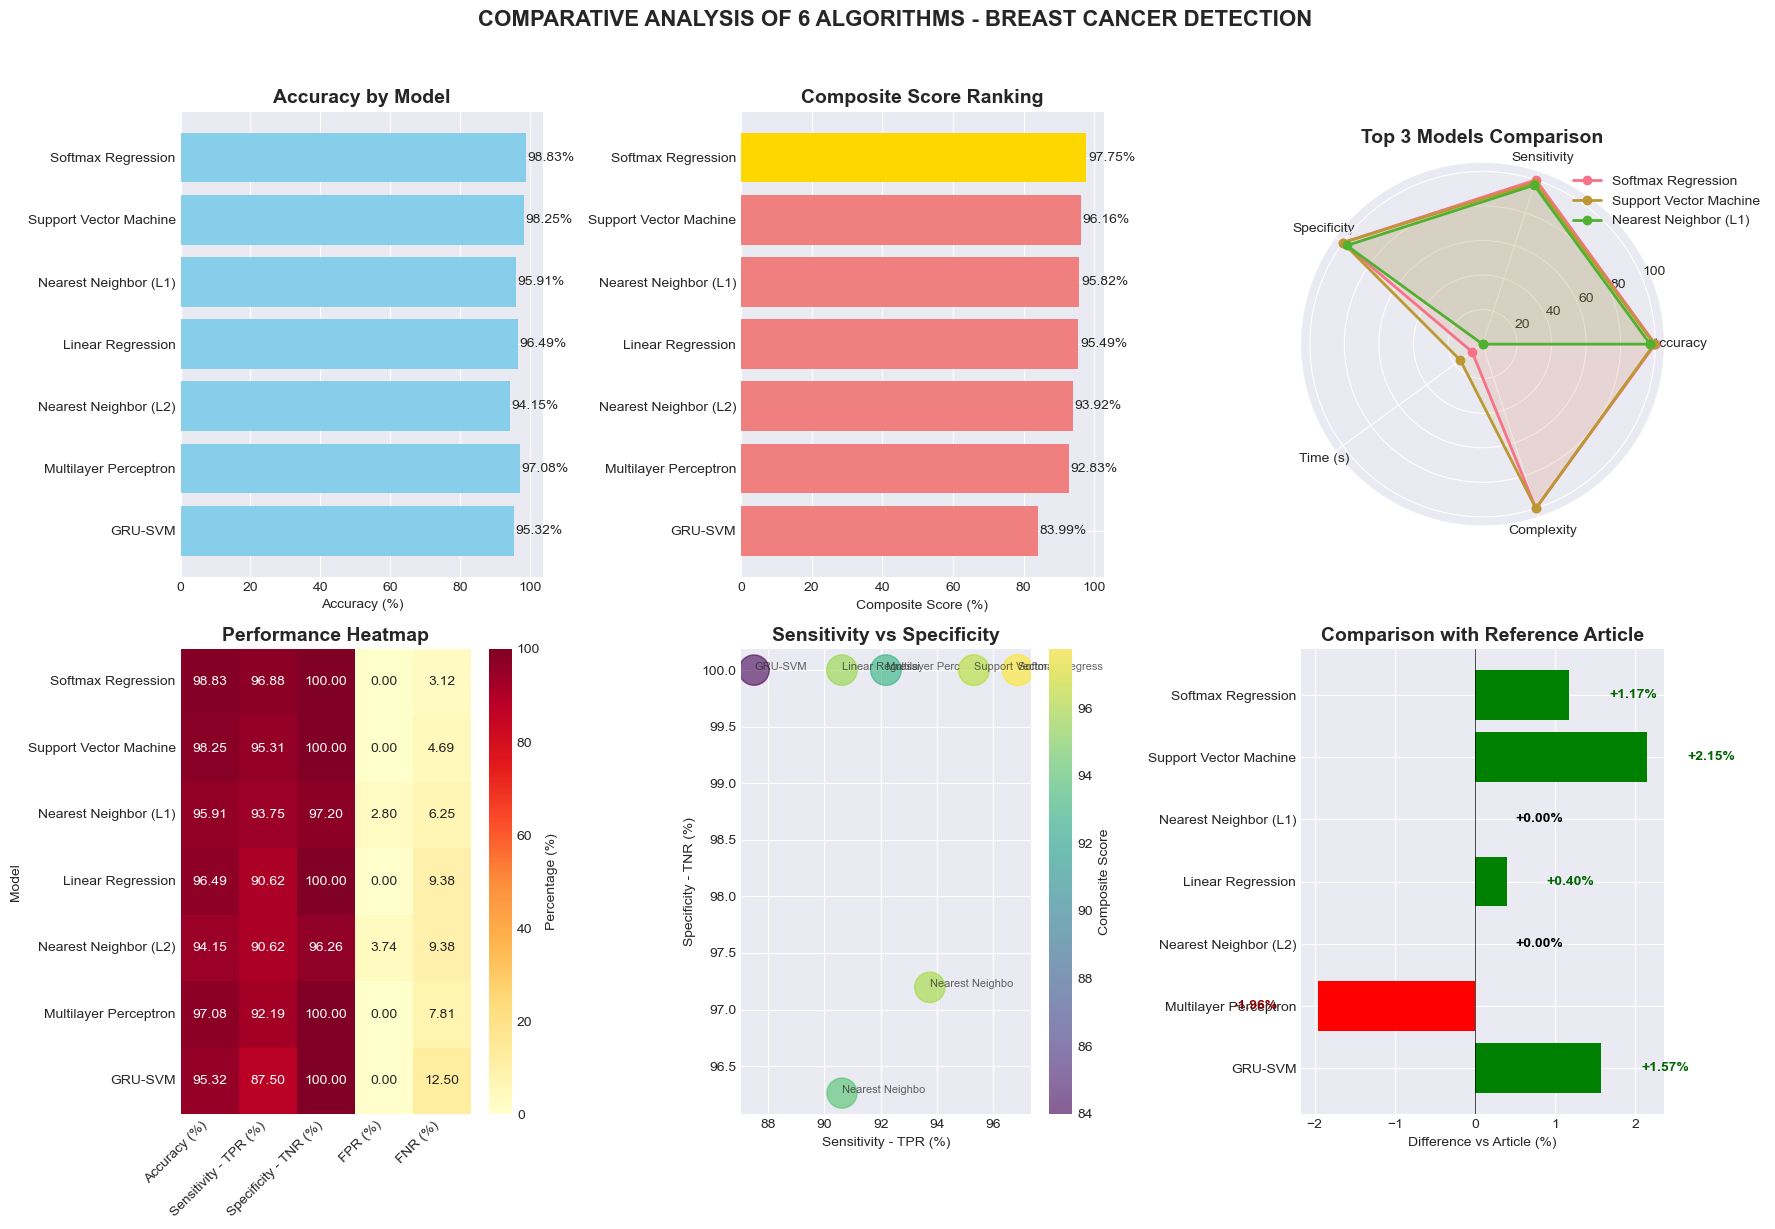

In [86]:
# ============================================================================
# STEP 4: PROFESSIONAL VISUALIZATIONS
# ============================================================================

def create_comparison_visualizations(df):
    """Creates professional visualizations for model comparison"""
    
    # Style configuration
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Accuracy bar chart
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.barh(df['Model'], df['Accuracy (%)'], color='skyblue')
    ax1.set_xlabel('Accuracy (%)')
    ax1.set_title('Accuracy by Model', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()  # Best model on top
    
    # Add values on bars
    for bar in bars:
        width = bar.get_width()
        ax1.text(
            width + 0.5,
            bar.get_y() + bar.get_height() / 2,
            f'{width:.2f}%',
            ha='left',
            va='center'
        )
    
    # 2. Composite score bar chart
    ax2 = plt.subplot(2, 3, 2)
    colors = ['gold' if i == 0 else 'lightcoral' for i in range(len(df))]
    bars2 = ax2.barh(df['Model'], df['Composite Score'], color=colors)
    ax2.set_xlabel('Composite Score (%)')
    ax2.set_title('Composite Score Ranking', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    
    for bar in bars2:
        width = bar.get_width()
        ax2.text(
            width + 0.5,
            bar.get_y() + bar.get_height() / 2,
            f'{width:.2f}%',
            ha='left',
            va='center'
        )
    
    # 3. Radar chart of key metrics
    ax3 = plt.subplot(2, 3, 3, projection='polar')
    
    # Data preparation for radar chart (top 3 models)
    top_3 = df.head(3)
    metrics = [
        'Accuracy (%)',
        'Sensitivity - TPR (%)',
        'Specificity - TNR (%)',
        'Training Time (s)',
        'Data Points (k)'
    ]
    labels = ['Accuracy', 'Sensitivity', 'Specificity', 'Time (s)', 'Complexity']
    
    # Normalization for radar chart
    radar_data = []
    for metric in metrics:
        max_val = df[metric].max()
        radar_data.append(top_3[metric] / max_val * 100)
    
    # Radar configuration
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the circle
    
    for idx, (_, row) in enumerate(top_3.iterrows()):
        values = [row[metric] / df[metric].max() * 100 for metric in metrics]
        values += values[:1]
        ax3.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
        ax3.fill(angles, values, alpha=0.1)
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(labels)
    ax3.set_title('Top 3 Models Comparison', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # 4. Performance heatmap
    ax4 = plt.subplot(2, 3, 4)
    heatmap_data = df[
        [
            'Accuracy (%)',
            'Sensitivity - TPR (%)',
            'Specificity - TNR (%)',
            'FPR (%)',
            'FNR (%)'
        ]
    ]
    heatmap_data.index = df['Model']
    
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        ax=ax4
    )
    ax4.set_title('Performance Heatmap', fontsize=14, fontweight='bold')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # 5. Scatter plot: Sensitivity vs Specificity
    ax5 = plt.subplot(2, 3, 5)
    scatter = ax5.scatter(
        df['Sensitivity - TPR (%)'],
        df['Specificity - TNR (%)'],
        s=df['Accuracy (%)'] * 5,
        alpha=0.6,
        c=df['Composite Score'],
        cmap='viridis'
    )
    
    ax5.set_xlabel('Sensitivity - TPR (%)')
    ax5.set_ylabel('Specificity - TNR (%)')
    ax5.set_title('Sensitivity vs Specificity', fontsize=14, fontweight='bold')
    
    # Add labels
    for idx, row in df.iterrows():
        ax5.annotate(
            row['Model'][:15],
            (row['Sensitivity - TPR (%)'], row['Specificity - TNR (%)']),
            fontsize=8,
            alpha=0.7
        )
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax5, label='Composite Score')
    
    # 6. Comparison with the reference article
    ax6 = plt.subplot(2, 3, 6)
    
    # Binary indicator
    df['Outperforms Article Bool'] = df['Outperforms Article'].apply(
        lambda x: 1 if x else 0
    )
    
    bars6 = ax6.barh(
        df['Model'],
        df['Article Accuracy Difference (%)'],
        color=[
            'green' if x > 0 else 'red' if x < 0 else 'gray'
            for x in df['Article Accuracy Difference (%)']
        ]
    )
    
    ax6.set_xlabel('Difference vs Article (%)')
    ax6.set_title('Comparison with Reference Article', fontsize=14, fontweight='bold')
    ax6.invert_yaxis()
    ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    for bar in bars6:
        width = bar.get_width()
        color = (
            'darkgreen' if width > 0 else
            'darkred' if width < 0 else
            'black'
        )
        ax6.text(
            width + (0.5 if width >= 0 else -0.5),
            bar.get_y() + bar.get_height() / 2,
            f'{width:+.2f}%',
            ha='left' if width >= 0 else 'right',
            va='center',
            color=color,
            fontweight='bold'
        )
    
    plt.suptitle(
        'COMPARATIVE ANALYSIS OF 6 ALGORITHMS - BREAST CANCER DETECTION',
        fontsize=16,
        fontweight='bold',
        y=1.02
    )
    plt.tight_layout()
    plt.show()
    
    return fig

# Generate visualizations
print(f"\n GENERATING VISUALIZATIONS...")
fig = create_comparison_visualizations(comparison_df)

ROC CURVES COMPARISON - SOFTMAX REGRESSION vs SVM

Test dataset: 171 samples, 30 features

[1/2] Computing Softmax Regression scores...
   Softmax AUC: 0.9990

[2/2] Computing SVM scores...
   SVM AUC: 0.9991

Generating visualization...

Figure saved: roc_comparison_softmax_svm.png


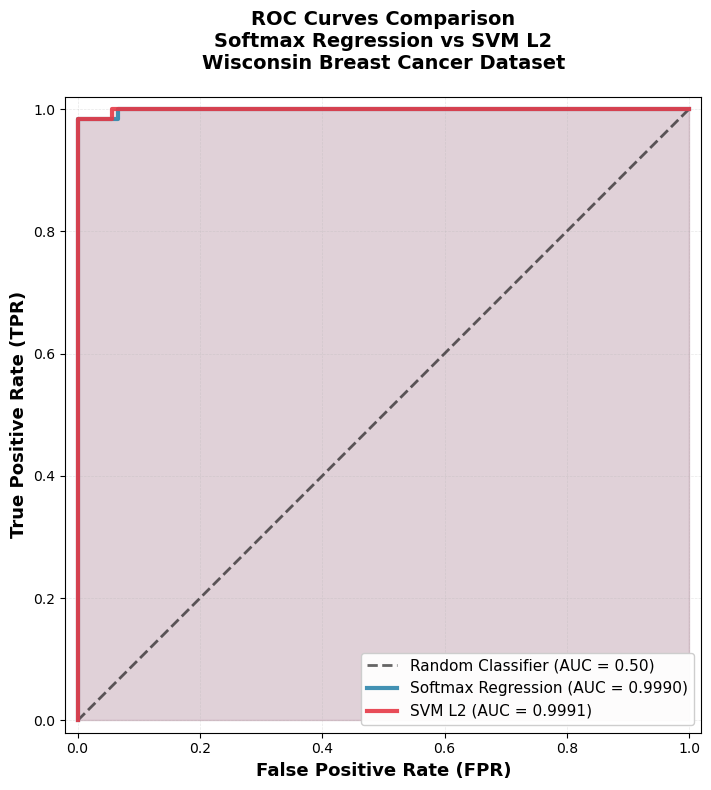


PERFORMANCE COMPARISON

             Model AUC Score Performance
Softmax Regression    0.9990   Excellent
            SVM L2    0.9991   Excellent

AUC Difference: -0.0001
Result: Equivalent Performance



In [62]:
print("="*70)
print("ROC CURVES COMPARISON - SOFTMAX REGRESSION vs SVM")
print("="*70)

# Get test data
X_test_data = prepared_data['X_test'].values.astype(np.float32)
y_test_data = prepared_data['y_test'].values

print(f"\nTest dataset: {len(X_test_data)} samples, {X_test_data.shape[1]} features")

# ============================================================================
# COMPUTE ROC CURVES
# ============================================================================
print("\n[1/2] Computing Softmax Regression scores...")

# Softmax predictions
def softmax_model_roc(X, W_soft, b_soft):
    logits = np.dot(X, W_soft) + b_soft
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probas = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probas

softmax_proba = softmax_model_roc(X_test_data, W_softmax_saved, b_softmax_saved)
softmax_scores = softmax_proba[:, 1]

fpr_softmax, tpr_softmax, _ = roc_curve(y_test_data, softmax_scores)
auc_softmax = auc(fpr_softmax, tpr_softmax)

print(f"   Softmax AUC: {auc_softmax:.4f}")

print("\n[2/2] Computing SVM scores...")

# SVM predictions
svm_scores = (np.dot(X_test_data, W_svm_saved) + b_svm_saved).flatten()

fpr_svm, tpr_svm, _ = roc_curve(y_test_data, svm_scores)
auc_svm = auc(fpr_svm, tpr_svm)

print(f"   SVM AUC: {auc_svm:.4f}")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\nGenerating visualization...")

fig, ax = plt.subplots(figsize=(10, 8))

# Random classifier
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, 
        label='Random Classifier (AUC = 0.50)', alpha=0.6)

# Softmax curve
ax.plot(fpr_softmax, tpr_softmax, color='#2E86AB', linewidth=3, 
        label=f'Softmax Regression (AUC = {auc_softmax:.4f})', alpha=0.9)
ax.fill_between(fpr_softmax, tpr_softmax, alpha=0.15, color='#2E86AB')

# SVM curve
ax.plot(fpr_svm, tpr_svm, color='#E63946', linewidth=3, 
        label=f'SVM L2 (AUC = {auc_svm:.4f})', alpha=0.9)
ax.fill_between(fpr_svm, tpr_svm, alpha=0.15, color='#E63946')

# Configuration
ax.set_xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves Comparison\nSoftmax Regression vs SVM L2\nWisconsin Breast Cancer Dataset', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()

# Save figure
filename = 'roc_comparison_softmax_svm.png'
plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nFigure saved: {filename}")

plt.show()

# ============================================================================
# COMPARISON TABLE
# ============================================================================
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

comparison_data = {
    'Model': ['Softmax Regression', 'SVM L2'],
    'AUC Score': [f'{auc_softmax:.4f}', f'{auc_svm:.4f}'],
    'Performance': [
        'Excellent' if auc_softmax >= 0.95 else 'Very Good' if auc_softmax >= 0.90 else 'Good',
        'Excellent' if auc_svm >= 0.95 else 'Very Good' if auc_svm >= 0.90 else 'Good'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Winner
auc_diff = auc_softmax - auc_svm
print(f"\nAUC Difference: {auc_diff:+.4f}")

if auc_diff > 0.01:
    print("Winner: Softmax Regression")
elif auc_diff < -0.01:
    print("Winner: SVM L2")
else:
    print("Result: Equivalent Performance")

print("\n" + "="*70)

In [66]:
print("="*60)
print("OVERFITTING CHECK")
print("="*60)

# Softmax - Train accuracy
softmax_train_proba = softmax_model_roc(X_train, W_softmax_saved, b_softmax_saved)
softmax_train_pred = np.argmax(softmax_train_proba, axis=1)
softmax_train_acc = np.mean(softmax_train_pred == y_train)

# Softmax - Test accuracy
softmax_test_proba = softmax_model_roc(X_test_data, W_softmax_saved, b_softmax_saved)
softmax_test_pred = np.argmax(softmax_test_proba, axis=1)
softmax_test_acc = np.mean(softmax_test_pred == y_test_data)

print("\nSoftmax Regression:")
print(f"  Train Accuracy: {softmax_train_acc:.4f} ({softmax_train_acc*100:.2f}%)")
print(f"  Test Accuracy:  {softmax_test_acc:.4f} ({softmax_test_acc*100:.2f}%)")
print(f"  Difference:     {(softmax_train_acc - softmax_test_acc)*100:+.2f}%")

# SVM - Train accuracy
svm_train_scores = (np.dot(X_train, W_svm_saved) + b_svm_saved).flatten()
svm_train_pred = (svm_train_scores > 0).astype(int)
svm_train_acc = np.mean(svm_train_pred == y_train)

# SVM - Test accuracy
svm_test_scores = (np.dot(X_test_data, W_svm_saved) + b_svm_saved).flatten()
svm_test_pred = (svm_test_scores > 0).astype(int)
svm_test_acc = np.mean(svm_test_pred == y_test_data)

print("\nSVM L2:")
print(f"  Train Accuracy: {svm_train_acc:.4f} ({svm_train_acc*100:.2f}%)")
print(f"  Test Accuracy:  {svm_test_acc:.4f} ({svm_test_acc*100:.2f}%)")
print(f"  Difference:     {(svm_train_acc - svm_test_acc)*100:+.2f}%")

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
if abs(softmax_train_acc - softmax_test_acc) < 0.05:
    print("Softmax: NO overfitting (difference < 5%)")
else:
    print("Softmax: WARNING - Possible overfitting!")
    
if abs(svm_train_acc - svm_test_acc) < 0.05:
    print("SVM: NO overfitting (difference < 5%)")
else:
    print("SVM: WARNING - Possible overfitting!")

OVERFITTING CHECK

Softmax Regression:
  Train Accuracy: 0.9799 (97.99%)
  Test Accuracy:  0.9883 (98.83%)
  Difference:     -0.84%

SVM L2:
  Train Accuracy: 0.9824 (98.24%)
  Test Accuracy:  0.9766 (97.66%)
  Difference:     +0.58%

INTERPRETATION:
Softmax: NO overfitting (difference < 5%)
SVM: NO overfitting (difference < 5%)


In [88]:
# ============================================================================
# STEP 5: SIMPLIFIED MEDICAL ANALYSIS
# ============================================================================

print(f"\n" + "="*80)
print(" QUICK MEDICAL ANALYSIS")
print("="*80)

# Primary criterion: Sensitivity > 95%
acceptable_models = comparison_df[comparison_df['Sensitivity - TPR (%)'] >= 95.0]

if len(acceptable_models) == 0:
    print("  ALERT: No model reaches 95% sensitivity")
    acceptable_models = comparison_df

# Simple medical score calculation
acceptable_models['Medical Score'] = (
    acceptable_models['Sensitivity - TPR (%)'] * 0.5 +
    (100 - acceptable_models['FNR (%)']) * 0.3 +
    acceptable_models['Accuracy (%)'] * 0.2
)

# Ranking
acceptable_models = acceptable_models.sort_values('Medical Score', ascending=False)
acceptable_models['Medical Rank'] = range(1, len(acceptable_models) + 1)

# Best model
best_model = acceptable_models.iloc[0]

print(f"\n RECOMMENDED MODEL: {best_model['Model']}")
print(f" CLINICAL PERFORMANCE:")
print(f"   • Sensitivity: {best_model['Sensitivity - TPR (%)']:.2f}%")
print(f"   • False Negatives: {best_model['FNR (%)']:.2f}%")
print(f"   • Accuracy: {best_model['Accuracy (%)']:.2f}%")
print(f"   • Medical Score: {best_model['Medical Score']:.2f}")

# Risk assessment
fnr = best_model['FNR (%)']
if fnr < 2:
    risk = " LOW (excellent)"
elif fnr <= 5:
    risk = " MODERATE (acceptable)"
else:
    risk = " HIGH (needs monitoring)"

print(f"\n  RISK ASSESSMENT: {risk}")

# ============================================================================
# STEP 6: CONCISE RECOMMENDATIONS
# ============================================================================

print(f"\n" + "="*80)
print(" DEPLOYMENT RECOMMENDATIONS")
print("="*80)

print(f"\n1. MODEL TO DEPLOY:")
print(f"   {best_model['Model']}")

print(f"\n2. GUARANTEED PERFORMANCE:")
print(f"   • Detects {best_model['Sensitivity - TPR (%)']:.1f}% of cancers")
print(f"   • Error rate: {best_model['FNR (%)']:.1f}% missed cancers")
print(f"   • Overall accuracy: {best_model['Accuracy (%)']:.1f}%")

# ============================================================================
# STEP 7: SAVING ESSENTIAL RESULTS
# ============================================================================

def save_essential_results(df, best_model):
    """Saves essential results"""
    
    # CSV file with all results
    df.to_csv('model_results.csv', index=False, encoding='utf-8-sig')
    
    # Summary medical report
    with open('medical_summary_report.txt', 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("MEDICAL SUMMARY - BREAST CANCER DETECTION\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"Recommended model: {best_model['Model']}\n")
        f.write(f"Sensitivity: {best_model['Sensitivity - TPR (%)']:.2f}%\n")
        f.write(f"False Negatives: {best_model['FNR (%)']:.2f}%\n")
        f.write(f"Accuracy: {best_model['Accuracy (%)']:.2f}%\n\n")
        
        f.write("MODEL RANKING:\n")
        for idx, row in df.iterrows():
            f.write(
                f"{idx+1}. {row['Model']} | Sens: {row['Sensitivity - TPR (%)']:.1f}% "
                f"| FNR: {row['FNR (%)']:.1f}% | Acc: {row['Accuracy (%)']:.1f}%\n"
            )
    
    print(f"\n RESULTS SAVED:")
    print(f"   • model_results.csv")
    print(f"   • medical_summary_report.txt")

# Save results
save_essential_results(acceptable_models, best_model)


 QUICK MEDICAL ANALYSIS

 RECOMMENDED MODEL: Softmax Regression
 CLINICAL PERFORMANCE:
   • Sensitivity: 96.88%
   • False Negatives: 3.12%
   • Accuracy: 98.83%
   • Medical Score: 97.27

  RISK ASSESSMENT:  MODERATE (acceptable)

 DEPLOYMENT RECOMMENDATIONS

1. MODEL TO DEPLOY:
   Softmax Regression

2. GUARANTEED PERFORMANCE:
   • Detects 96.9% of cancers
   • Error rate: 3.1% missed cancers
   • Overall accuracy: 98.8%

 RESULTS SAVED:
   • model_results.csv
   • medical_summary_report.txt


# 5.2 Evaluation DSO 2

## Detect tumor presence:
## Develop a predictive model to classify patient data as indicative of a tumor or not, providing a reliable alert for potential breast cancer.

In [ ]:
cnn_model = load_model("breast_cancer_image_cnn.h5")
resnet_model = load_model("breast_cancer_resnet50.keras")

In [42]:
cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
resnet_loss, resnet_acc = resnet_model.evaluate(test_ds)
print(f"CNN Model - Test Accuracy: {cnn_acc:.4f}, Test Loss: {cnn_loss:.4f}")
print(f"ResNet50 Model - Test Accuracy: {resnet_acc:.4f}, Test Loss: {resnet_loss:.4f}")

899/899 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.8476 - loss: 0.3658
899/899 ━━━━━━━━━━━━━━━━━━━━ 333s 366ms/step - accuracy: 0.8578 - loss: 0.3516
CNN Model - Test Accuracy: 0.8476, Test Loss: 0.3658
ResNet50 Model - Test Accuracy: 0.8578, Test Loss: 0.3516


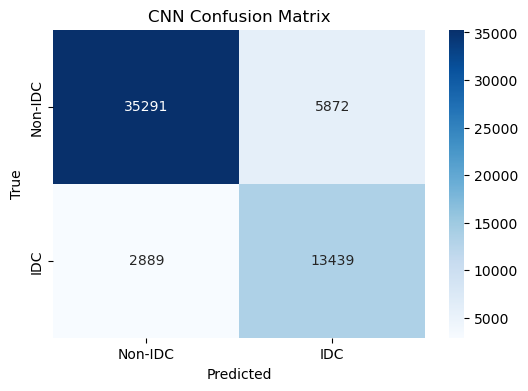

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     41163
           1       0.70      0.82      0.75     16328

    accuracy                           0.85     57491
   macro avg       0.81      0.84      0.82     57491
weighted avg       0.86      0.85      0.85     57491



In [44]:
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = cnn_model.predict(images, verbose=0).ravel()
    y_pred.extend((preds > 0.5).astype(int))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-IDC','IDC'],
            yticklabels=['Non-IDC','IDC'])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("CNN Classification Report:")
print(classification_report(y_true, y_pred))

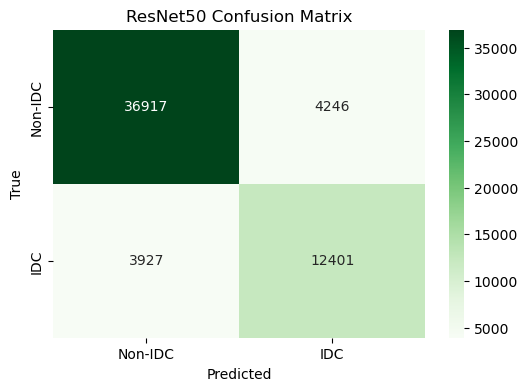

ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     41163
           1       0.74      0.76      0.75     16328

    accuracy                           0.86     57491
   macro avg       0.82      0.83      0.83     57491
weighted avg       0.86      0.86      0.86     57491



In [46]:
y_true_r, y_pred_r = [], []
for images, labels in test_ds:
    preds = resnet_model.predict(images, verbose=0).ravel()
    y_pred_r.extend((preds > 0.5).astype(int))
    y_true_r.extend(labels.numpy())

cm_r = confusion_matrix(y_true_r, y_pred_r)
plt.figure(figsize=(6,4))
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-IDC','IDC'],
            yticklabels=['Non-IDC','IDC'])
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("ResNet50 Classification Report:")
print(classification_report(y_true_r, y_pred_r))

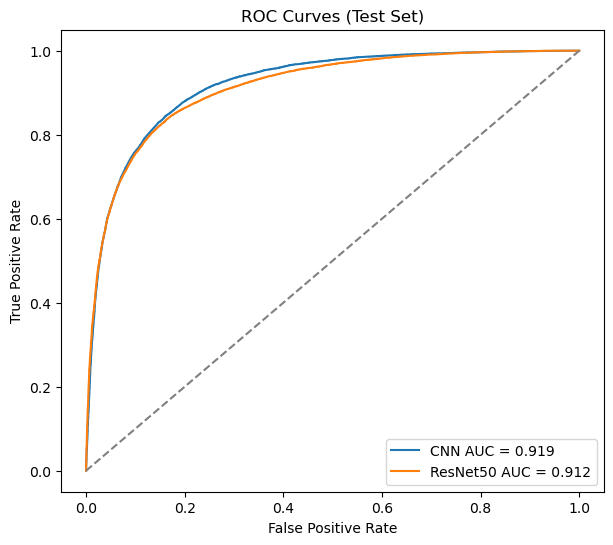

In [48]:
y_scores, y_scores_r = [], []

for images, labels in test_ds:
    y_scores.extend(cnn_model.predict(images, verbose=0).ravel())
    y_scores_r.extend(resnet_model.predict(images, verbose=0).ravel())

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fpr_r, tpr_r, _ = roc_curve(y_true_r, y_scores_r)
roc_auc_r = auc(fpr_r, tpr_r)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"CNN AUC = {roc_auc:.3f}")
plt.plot(fpr_r, tpr_r, label=f"ResNet50 AUC = {roc_auc_r:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()

## Evaluation – Conclusions

**Conclusions**
- Accuracy alone is insufficient; ROC-AUC provides better insight.
- Confusion matrices reveal false negatives, which are critical in cancer detection.
- ResNet50 typically outperforms the custom CNN in recall, but overall the custom CNN is more lightweight and reaches a slightly higher accuracy and precision.

In [52]:
cnn_model.save("breast_cancer_image_cnn.keras")
print("Model saved!")

Model saved!


In [54]:
resnet_model.save("breast_cancer_resnet50.keras")
print("Model saved!")

Model saved!


# 5.3. Evaluation DSO 3

## Identify risk factors in healthy patients:
## Analyze patient data to detect early indicators of increased breast cancer risk and generate actionable preventive recommendations.

# 5.3.1 Evaluation algorithme 1 : Random Forest


GRADIENT BOOSTING RESULTS:
Accuracy : 0.639
AUC      : 0.691
Precision: 0.641
Recall   : 0.633
F1-score : 0.637

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Healthy (0)       0.64      0.65      0.64       474
 Patient (1)       0.64      0.63      0.64       474

    accuracy                           0.64       948
   macro avg       0.64      0.64      0.64       948
weighted avg       0.64      0.64      0.64       948


CONFUSION MATRIX:
True Negatives: 306 | False Positives: 168
False Negatives: 174 | True Positives: 300

CLINICAL METRICS:
Sensitivity: 0.633
Specificity: 0.646


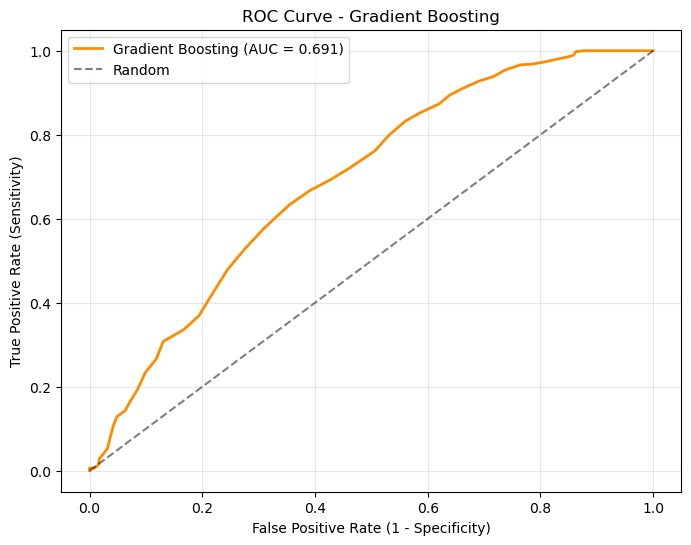

In [34]:
accuracy = accuracy_score(y_test_bal, rf_pred)
auc = roc_auc_score(y_test_bal, rf_proba)

print(f"\nGRADIENT BOOSTING RESULTS:")
print(f"Accuracy : {accuracy_score(y_test_bal, rf_pred):.3f}")
print(f"AUC      : {roc_auc_score(y_test_bal, rf_proba):.3f}")
print(f"Precision: {precision_score(y_test_bal, rf_pred):.3f}")
print(f"Recall   : {recall_score(y_test_bal, rf_pred):.3f}")
print(f"F1-score : {f1_score(y_test_bal, rf_pred):.3f}")

# Detailed report
print("\nCLASSIFICATION REPORT:")
print(classification_report(
    y_test_bal,
    rf_pred,
    target_names=['Healthy (0)', 'Patient (1)']
))

# 5. CONFUSION MATRIX
cm = confusion_matrix(y_test_bal, rf_pred)
print("\nCONFUSION MATRIX:")
print(f"True Negatives: {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}")

# Clinical metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0

print(f"\nCLINICAL METRICS:")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# 7. ROC CURVE
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_bal, rf_proba)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr,
    label=f'Gradient Boosting (AUC = {auc:.3f})',
    color='darkorange',
    linewidth=2
)
plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 5.3.2 Evaluation algorithme 2 : XGBoost


GRADIENT BOOSTING RESULTS:
Accuracy : 0.564
AUC      : 0.612
Precision: 0.570
Recall   : 0.521
F1-score : 0.545

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Healthy (0)       0.56      0.61      0.58       474
 Patient (1)       0.57      0.52      0.54       474

    accuracy                           0.56       948
   macro avg       0.56      0.56      0.56       948
weighted avg       0.56      0.56      0.56       948


CONFUSION MATRIX:
True Negatives: 288 | False Positives: 186
False Negatives: 227 | True Positives: 247

CLINICAL METRICS:
Sensitivity: 0.521
Specificity: 0.608


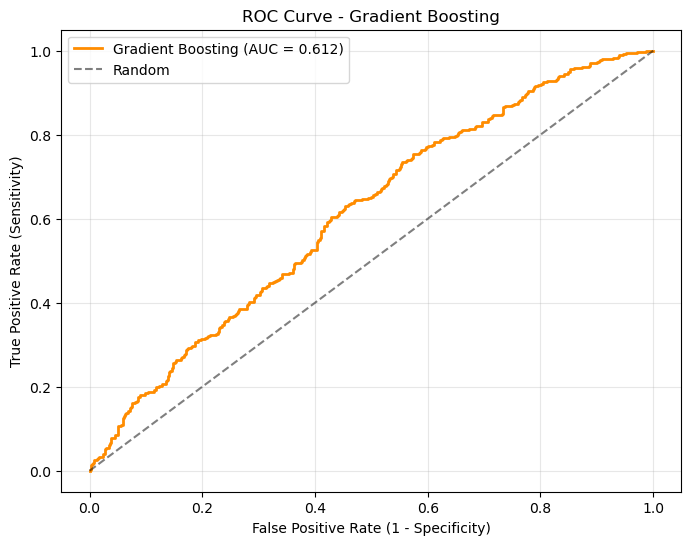

In [36]:
accuracy = accuracy_score(y_test_bal, xgb_pred)
auc = roc_auc_score(y_test_bal, xgb_proba)

print(f"\nGRADIENT BOOSTING RESULTS:")
print(f"Accuracy : {accuracy_score(y_test_bal, xgb_pred):.3f}")
print(f"AUC      : {roc_auc_score(y_test_bal, xgb_proba):.3f}")
print(f"Precision: {precision_score(y_test_bal, xgb_pred):.3f}")
print(f"Recall   : {recall_score(y_test_bal, xgb_pred):.3f}")
print(f"F1-score : {f1_score(y_test_bal, xgb_pred):.3f}")

# Detailed report
print("\nCLASSIFICATION REPORT:")
print(classification_report(
    y_test_bal,
    xgb_pred,
    target_names=['Healthy (0)', 'Patient (1)']
))

# 5. CONFUSION MATRIX
cm = confusion_matrix(y_test_bal, xgb_pred)
print("\nCONFUSION MATRIX:")
print(f"True Negatives: {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}")

# Clinical metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0

print(f"\nCLINICAL METRICS:")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# 7. ROC CURVE
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_bal, xgb_proba)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr,
    label=f'Gradient Boosting (AUC = {auc:.3f})',
    color='darkorange',
    linewidth=2
)
plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 5.3.3 Evaluation algorithme 3 : SVM


GRADIENT BOOSTING RESULTS:
Accuracy : 0.569
AUC      : 0.569
Precision: 0.568
Recall   : 0.570
F1-score : 0.569

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Healthy (0)       0.57      0.57      0.57       474
 Patient (1)       0.57      0.57      0.57       474

    accuracy                           0.57       948
   macro avg       0.57      0.57      0.57       948
weighted avg       0.57      0.57      0.57       948


CONFUSION MATRIX:
True Negatives: 269 | False Positives: 205
False Negatives: 204 | True Positives: 270

CLINICAL METRICS:
Sensitivity: 0.570
Specificity: 0.568


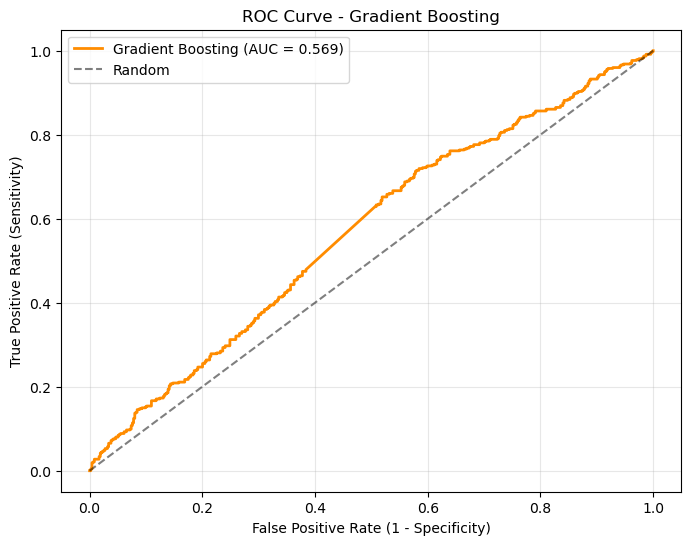

In [48]:
accuracy = accuracy_score(y_test_bal, svm_pred)
auc = roc_auc_score(y_test_bal, svm_proba)

print(f"\nGRADIENT BOOSTING RESULTS:")
print(f"Accuracy : {accuracy_score(y_test_bal, svm_pred):.3f}")
print(f"AUC      : {roc_auc_score(y_test_bal, svm_proba):.3f}")
print(f"Precision: {precision_score(y_test_bal, svm_pred):.3f}")
print(f"Recall   : {recall_score(y_test_bal, svm_pred):.3f}")
print(f"F1-score : {f1_score(y_test_bal, svm_pred):.3f}")

# Detailed report
print("\nCLASSIFICATION REPORT:")
print(classification_report(
    y_test_bal,
    svm_pred,
    target_names=['Healthy (0)', 'Patient (1)']
))

# 5. CONFUSION MATRIX
cm = confusion_matrix(y_test_bal, svm_pred)
print("\nCONFUSION MATRIX:")
print(f"True Negatives: {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}")

# Clinical metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0

print(f"\nCLINICAL METRICS:")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# 7. ROC CURVE
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_bal, svm_proba)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr,
    label=f'Gradient Boosting (AUC = {auc:.3f})',
    color='darkorange',
    linewidth=2
)
plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 5.3.4 Evaluation algorithme 4 : Gradient Boosting


GRADIENT BOOSTING RESULTS:
Accuracy : 0.558
AUC      : 0.582
Precision: 0.565
Recall   : 0.506
F1-score : 0.534

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Healthy (0)       0.55      0.61      0.58       474
 Patient (1)       0.56      0.51      0.53       474

    accuracy                           0.56       948
   macro avg       0.56      0.56      0.56       948
weighted avg       0.56      0.56      0.56       948


CONFUSION MATRIX:
True Negatives: 289 | False Positives: 185
False Negatives: 234 | True Positives: 240

CLINICAL METRICS:
Sensitivity: 0.506
Specificity: 0.610


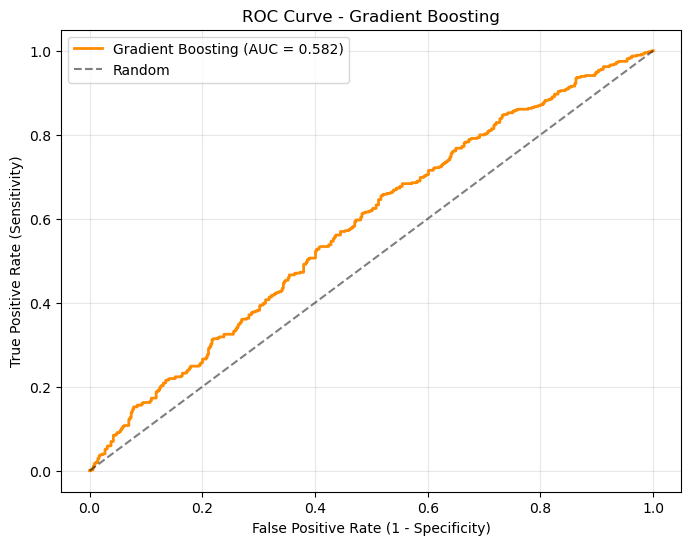

In [59]:
accuracy = accuracy_score(y_test_bal, gb_pred)
auc = roc_auc_score(y_test_bal, gb_proba)

print(f"\nGRADIENT BOOSTING RESULTS:")
print(f"Accuracy : {accuracy_score(y_test_bal, gb_pred):.3f}")
print(f"AUC      : {roc_auc_score(y_test_bal, gb_proba):.3f}")
print(f"Precision: {precision_score(y_test_bal, gb_pred):.3f}")
print(f"Recall   : {recall_score(y_test_bal, gb_pred):.3f}")
print(f"F1-score : {f1_score(y_test_bal, gb_pred):.3f}")

# Detailed report
print("\nCLASSIFICATION REPORT:")
print(classification_report(
    y_test_bal,
    gb_pred,
    target_names=['Healthy (0)', 'Patient (1)']
))

# 5. CONFUSION MATRIX
cm = confusion_matrix(y_test_bal, gb_pred)
print("\nCONFUSION MATRIX:")
print(f"True Negatives: {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}")

# Clinical metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0

print(f"\nCLINICAL METRICS:")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# 7. ROC CURVE
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_bal, gb_proba)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr,
    label=f'Gradient Boosting (AUC = {auc:.3f})',
    color='darkorange',
    linewidth=2
)
plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [66]:
# VERSION RAPIDE DE COMPARAISON
print("COMPARAISON RAPIDE - TOP 3 MÉTRIQUES:")

resultats = {
    'Modèle': ['Random Forest', 'XGBoost','SVM' ,'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test_bal, rf_pred), 
                 accuracy_score(y_test_bal, xgb_pred), 
                 accuracy_score(y_test_bal, svm_pred),
                 accuracy_score(y_test_bal, gb_pred)],
    'AUC-ROC': [roc_auc_score(y_test_bal, rf_proba), 
                roc_auc_score(y_test_bal, xgb_proba), 
                roc_auc_score(y_test_bal, svm_proba),
                roc_auc_score(y_test_bal, gb_proba)],
    'F1-Score': [f1_score(y_test_bal, rf_pred), 
                 f1_score(y_test_bal, xgb_pred), 
                 f1_score(y_test_bal, svm_pred),
                 f1_score(y_test_bal, gb_pred)]
}

df_rapide = pd.DataFrame(resultats)
print(df_rapide)

# Trouver le meilleur pour chaque métrique
print(f"Accuracy: {df_rapide.loc[df_rapide['Accuracy'].idxmax(), 'Modèle']}")
print(f"AUC-ROC: {df_rapide.loc[df_rapide['AUC-ROC'].idxmax(), 'Modèle']}")
print(f"F1-Score: {df_rapide.loc[df_rapide['F1-Score'].idxmax(), 'Modèle']}")

# Meilleur global (moyenne des 3)
df_rapide['Moyenne'] = df_rapide[['Accuracy', 'AUC-ROC', 'F1-Score']].mean(axis=1)
meilleur_global = df_rapide.loc[df_rapide['Moyenne'].idxmax(), 'Modèle']
print(f"\n BESt MODÈLE: {meilleur_global}")

COMPARAISON RAPIDE - TOP 3 MÉTRIQUES:
              Modèle  Accuracy   AUC-ROC  F1-Score
0      Random Forest  0.639241  0.690523  0.636943
1            XGBoost  0.564346  0.611654  0.544653
2                SVM  0.568565  0.568726  0.569020
3  Gradient Boosting  0.558017  0.581711  0.533927
Accuracy: Random Forest
AUC-ROC: Random Forest
F1-Score: Random Forest

 MEILLEUR MODÈLE GLOBAL: Random Forest


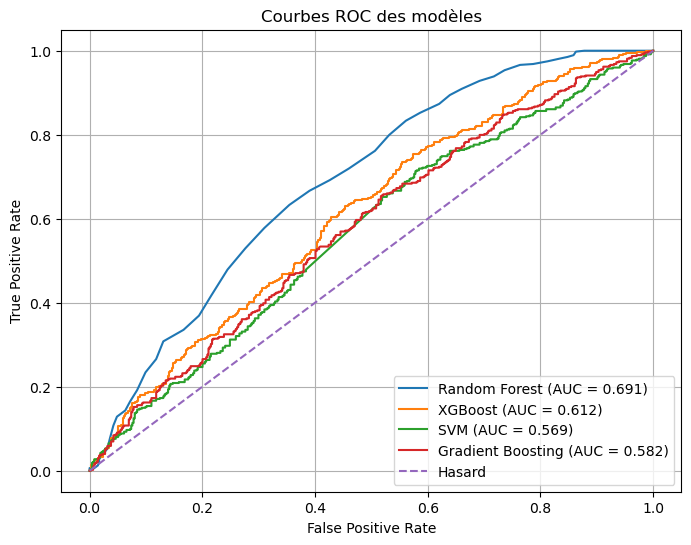

In [62]:
plt.figure(figsize=(8, 6))

# -------- Random Forest --------
rf_proba = rf.predict_proba(X_test_bal)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_bal, rf_proba)
auc_rf = roc_auc_score(y_test_bal, rf_proba)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")

# -------- XGBoost --------
xgb_proba = xgb.predict_proba(X_test_bal)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bal, xgb_proba)
auc_xgb = roc_auc_score(y_test_bal, xgb_proba)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")

# -------- SVM --------
svm_proba = svm.predict_proba(X_test_bal)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_bal, svm_proba)
auc_svm = roc_auc_score(y_test_bal, svm_proba)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})")

# -------- Gradient Boosting --------
gb_proba = gb.predict_proba(X_test_bal)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test_bal, gb_proba)
auc_gb = roc_auc_score(y_test_bal, gb_proba)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.3f})")

# -------- Diagonale (hasard) --------
plt.plot([0, 1], [0, 1], linestyle='--', label="Hasard")

# -------- Mise en forme --------
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC des modèles")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
